In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pickle
import time as time
from fast_histogram import histogram1d, histogram2d
from scipy.optimize import curve_fit
import json
import h5py
from tqdm.notebook import tqdm

tstart = time.time()

import tpx3awkward as tpx
import tpxspdc as ts

import pandas as pd
pd.set_option('display.max_columns', None)

from tiled.client import from_uri
db = from_uri('https://tiled.nsls2.bnl.gov', 'dask')['chx']['raw']

# load data

In [2]:
sid = 164277

In [3]:
### Modify these as needed!
r_md = db[sid].start

# Basic scan info:
scan_info = {
    'sid' : sid,
    'Epump': r_md['Epump'],
    'dd' : r_md['dd'], 
    'del_theta' : r_md['del_theta'],
    'theta' : r_md['theta'],
    'x_cen' : r_md['x_cen'],
    'y_cen' : r_md['y_cen']
}

# Variables for controlling what cells run:
plot_basic_info = True
four_chip = False # if false, uses pixel by pixel method

# dp selection vars
dp_search = True
x_minus_offset = -4
x_plus_offset = 4
y_minus_offset = -4
y_plus_offset = 4

all_selections = True # should keep True for now until more condensed version is available (not fully implemented)

# Variables for saving intermediate dataframes:
save_tot = False
save_pairs = False
save_selections = False

save_folder = "/nsls2/data/chx/proposals/2025-1/pass-316251/Results/"

# Selection variables
tot_offset = 25 
dt_selection_range = 2 # in sigma_t
Etot_selection_range = 2 # in del_E t
dp_selection_range = 10 # in pixels

# Whether to find nominal t0 / E0 values or use the values specified below
find_nominals = True
t0 = 0
tsigma = 20
E0 = 15
Esigma = .4

# Variables for saving plots:
save_plots = False
plot_folder = 'test' # maybe should add code to check if it exists and make if not.

# We should analyzing data after it has been corrected by adding dummy pixels between chips.
npixels = 514 # By default, tpx3awkward.add_centroid_cols does this now.

pixel_to_mm = 0.055 # 55 microns is 0.055 millimeters
npixels_mm = npixels * pixel_to_mm

# Figure size parameters.
labelsize = 10
ticksize = 8
legendsize = 8
figsize = (7.08, 3.54)
figsize_sing = (3.54, 3.54)
dpi = 300
#mpl.rcParams['figure.dpi'] = dpi

max_load = 0

In [4]:
### Load the data in, fix columns, mask out pixels if necessary, and channel them.
### Maybe the data could be resaved at the end, since this takes a long time?

"""
try: 
    cfpath = tpx.get_concat_fpath(scan_info['sid'], db)
    print(cfpath)
except:
    raise Exception("Could not find the concatenated filepath! May need to run the concatenate pipeline.")
"""
# cfpath = '/nsls2/data/chx/legacy/data/2024/02/03/c731d48e-8b0e-4f17-b286_cent.h5'
# If you need to manually open a file, comment the lines above and uncomment the line below and set there:
# cfpath = '/nsls2/data/chx/legacy/analysis/2023_2/qmicroscope/old_data/127682_cent.h5'

t1 = time.time()
print("Loading centroided data:")

files = tpx.converted_path(db[sid]['primary']['data']['tpx3_files_raw_filepaths'][0].compute(), cent=True)
_dfs = []

if max_load != 0:
    files = files[0:max_load]

for file in tqdm(files):
    if not file.exists():
        from pathlib import Path
        tpx_file = Path(str(file).replace('Compressed_Data', 'assets').replace('_cent.h5', '.tpx3'))
        tpx.convert_tpx_file(tpx_file, print_details=False)        
    elif file.stat().st_size == 0:
        from pathlib import Path
        tpx_file = Path(str(file).replace('Compressed_Data', 'assets').replace('_cent.h5', '.tpx3'))
        tpx.convert_tpx_file(tpx_file, print_details=False)
    _dfs.append(pd.read_hdf(file))
_df = pd.concat(_dfs)

t2 = time.time()
print(f"...loading complete after {(t2-t1):.1f} seconds. Found {len(_df)} events. Fixing large pixel gap and additional centroid columns:")
_df = tpx.add_centroid_cols(_df)
t2b = time.time()
print(f"...gap and additional centroid columns complete after {(t2b-t2):.1f} seconds. Removing dead pixels:")
# beamstop_condition = ~((_df['xc'] >= 250) & (_df['xc'] <= 260) & (_df['yc'] >= 250) & (_df['yc'] <= 260)) # this is necessary because of a dead pixel in the middle
# _df = _df[beamstop_condition].reset_index(drop=True)
# _df = _df.drop(_df[_df['y'] > 513].index)
# _df = _df.drop(_df[_df['x'] > 513].index)

conditions = (
    ~((_df['xc'] >= 250) & (_df['xc'] <= 260) & (_df['yc'] >= 250) & (_df['yc'] <= 260))
)

_df = _df[conditions].reset_index(drop=True)
t3 = time.time()
print(f"...Dead pixels removed after {(t3-t2b):.1f} seconds. Channeling:")
_df = ts.channel_optimized(_df)
t4 = time.time()
print(f"...channeling complete after {(t4-t3):.1f} seconds. Total elapsed time of this section is {(t4-t1):.1f} seconds.")

_df

Loading centroided data:


  0%|          | 0/1800 [00:00<?, ?it/s]

...loading complete after 86.0 seconds. Found 2143261648 events. Fixing large pixel gap and additional centroid columns:
...gap and additional centroid columns complete after 96.6 seconds. Removing dead pixels:
...Dead pixels removed after 123.5 seconds. Channeling:
...channeling complete after 145.8 seconds. Total elapsed time of this section is 451.9 seconds.


t          xc          yc  ToT_max  ToT_sum  n    x  \
0                 8904166  107.000000   32.000000      475      475  1  107   
1                 8904694  374.000000  210.000000      500      500  1  374   
2                 8905060   27.440001  395.000000      350      625  2   27   
3                 8906326  498.000000  129.000000      450      450  1  498   
4                 8907887  342.000000  395.000000      525      525  1  342   
...                   ...         ...         ...      ...      ... ..  ...   
2143257129  1155456416032   25.000000  459.000000      525      525  1   25   
2143257130  1155456418641   84.000000  457.428558      300      525  2   84   
2143257131  1155456422046  142.000000  433.366669      475      750  2  142   
2143257132  1155456423020   77.000000  449.500000      325      650  2   77   
2143257133  1155456423349  212.559998  445.000000      350      625  2  213   

              y          t_ns       index  chan  
0            32  1.391276e+07           0     4  
1           210  1.391358e+07           1     1  
2           395  1.391416e+07           2     3  
3           129  1.391613e+07           3     1  
4           395  1.391857e+07           4     2  
...         ...           ...         ...   ...  
2143257129  459  1.805401e+12  2143257129     3  
2143257130  457  1.805401e+12  2143257130     3  
2143257131  433  1.805401e+12  2143257131     3  
2143257132  450  1.805401e+12  2143257132     3  
2143257133  445  1.805401e+12  2143257133     3  

[2143257134 rows x 11 columns]

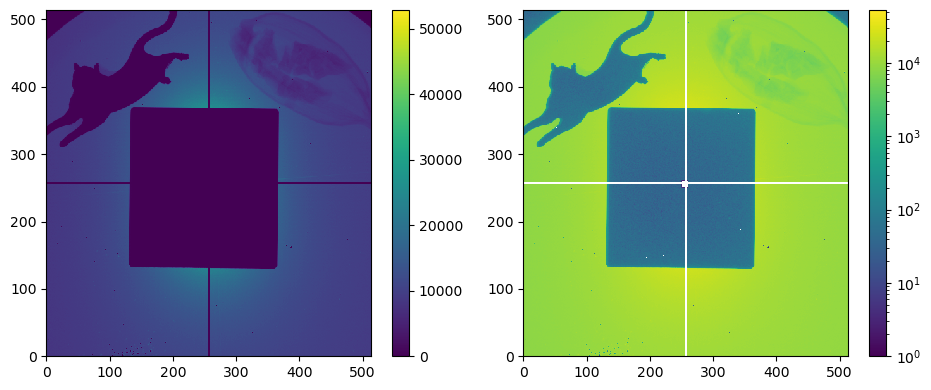

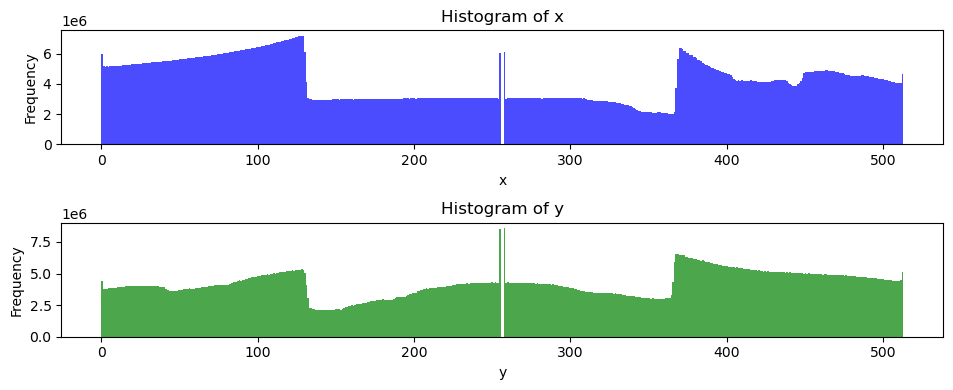

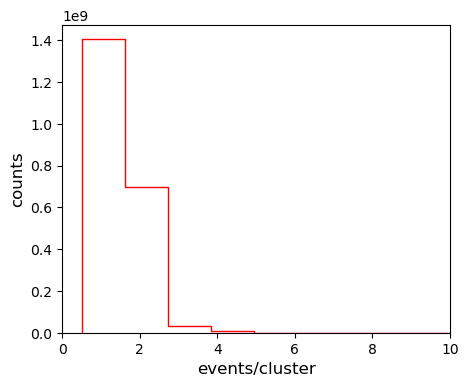

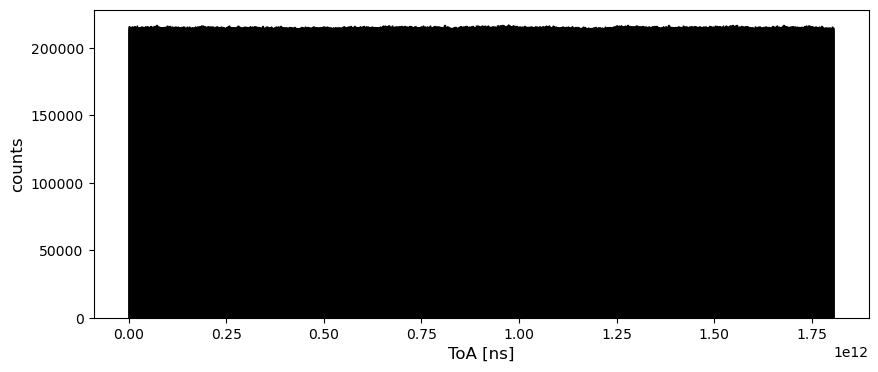

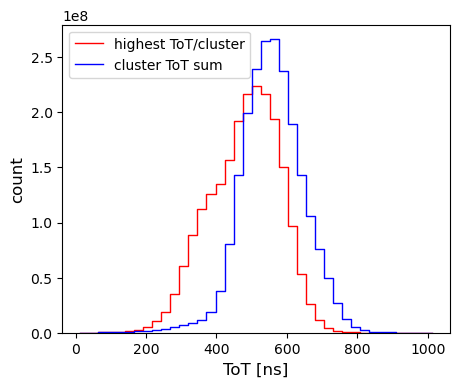

In [5]:
### Plot some basic info of the raw data:

if plot_basic_info:

    nbins = 514

    hist_data = histogram2d(_df['xc'], _df['yc'], range=[[0, 513], [0, 513]], bins=npixels)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))
    h = ax0.pcolormesh(hist_data)
    fig.colorbar(h, ax = ax0)
    h = ax1.pcolormesh(hist_data, norm=mpl.colors.LogNorm())
    fig.colorbar(h, ax = ax1)
    fig.tight_layout()
    plt.show()

    fig, axs = plt.subplots(2, 1, figsize=(9.5, 4))
    axs[0].hist(_df['xc'], bins=514, color='blue', alpha=0.7)
    axs[0].set_title('Histogram of x')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('Frequency')
    axs[1].hist(_df['yc'], bins=514, color='green', alpha=0.7)
    axs[1].set_title('Histogram of y')
    axs[1].set_xlabel('y')
    axs[1].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    nbins = 10
    dmin = 0
    dmax = 10
    bins = np.linspace(dmin, dmax, nbins)
    bsize = bins[1]-bins[0]
    bshift = bsize/2
    hist_data = histogram1d(_df['n'], bins = nbins, range = [dmin, dmax])
    bins = np.linspace(dmin, dmax, nbins)
    fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
    plt.step(bins+0.5, hist_data, 'r', linewidth = 1)
    plt.ylim([0, np.max(hist_data)*1.05])
    plt.xlim([dmin, dmax])
    plt.xlabel('events/cluster',fontsize = 12)
    plt.ylabel('counts',fontsize = 12)
    plt.show()

    nbins = 10000
    dmin = _df['t_ns'].min()
    dmax = _df['t_ns'].max()
    bins = np.linspace(dmin, dmax, nbins)
    bsize = bins[1]-bins[0]
    bshift = bsize/2
    hist_data = histogram1d(_df['t_ns'], bins = nbins, range = [dmin, dmax])
    bins = np.linspace(dmin, dmax, nbins)
    fig, ax0 = plt.subplots(ncols=1, figsize=(10, 4))
    plt.bar(bins+bshift,hist_data ,bsize, color = 'r', edgecolor = 'k')
    plt.xlabel('ToA [ns]',fontsize = 12)
    plt.ylabel('counts',fontsize = 12)
    plt.show()

    nbins = 40
    dmin = 0
    dmax = 1000
    bins = np.linspace(dmin, dmax, nbins)
    bsize = bins[1]-bins[0]
    bshift = bsize/2
    hist_data_1 = histogram1d(_df['ToT_max'], bins = nbins, range = [dmin, dmax])
    hist_data_2 = histogram1d(_df['ToT_sum'], bins = nbins, range = [dmin, dmax])
    bins = np.linspace(dmin, dmax, nbins)
    fig, ax0 = plt.subplots(ncols=1, figsize=(5, 4))
    plt.step(bins+bshift,hist_data_1, 'r', linewidth = 1, label='highest ToT/cluster')
    plt.step(bins+bshift,hist_data_2, 'b', linewidth = 1, label='cluster ToT sum')
    plt.ylim([0, np.max([hist_data_1, hist_data_2])*1.05])
    plt.xlabel('ToT [ns]',fontsize = 12)
    plt.ylabel('count',fontsize = 12)
    plt.legend()
    plt.show()

# analysis

In [6]:
### ToT filtering

t5 = time.time()

print("Filtering...")
if four_chip:
    
    optimal_tots = [350, 375, 425, 425] # Set optimal ToTs (4 chip method).  tpxspdc also has pixel by pixel method
    optimal_tots = [375, 400, 450, 450] # +25 ns of original values
    df = ts.tot_filter_quad(_df, optimal_tots)
    
else:
    
    with open("/nsls2/data/chx/legacy/analysis/2023_2/qmicroscope/Results/test", "rb") as fp:
        opt_tots = pickle.load(fp)

        opt_tots = np.asarray(opt_tots, dtype=np.int32) - tot_offset

        expanded_tots = np.zeros((514, 514, 1))
        expanded_tots[:256, :256, :] = opt_tots[:256, :256, :]
        expanded_tots[:256, 258:, :] = opt_tots[:256, 256:, :]
        expanded_tots[258:, :256, :] = opt_tots[256:, :256, :]
        expanded_tots[258:, 258:, :] = opt_tots[256:, 256:, :]
        expanded_tots[256:258, :, :] = 600
        expanded_tots[:, 256:258, :] = 600

    df = ts.tot_filter_pixel_pandas(_df, expanded_tots, prints = True)
    
t6 = time.time()

print(f"...complete after {(t6-t5):.1f} seconds. Saving:")

if save_tot:
    df.to_hdf(save_folder + "data/tot/tot_{}.h5".format(scan_info['sid']), format='table', key='df', mode='w')
    with h5py.File(save_folder + "data/tot/tot_{}.h5".format(scan_info['sid']), 'a') as h5f:
        h5f.create_dataset('scan_info', data=np.array(json.dumps(scan_info), dtype='S'))
    print(f"...saved after {(time.time()-t6):.1f} seconds.")
print(len(df))

Filtering...
Dropped rows after ToT filtering: 2096561970
...complete after 23.3 seconds. Saving:
...saved after 17.9 seconds.
46695164


In [7]:
### Find pairs by smallest time difference and add more info.

scan_info['del_theta'] = abs(scan_info['del_theta'])

t7 = time.time()
print("Finding pairs...")
df_pairs = ts.get_pairs_pandas(df, chans1 = [1,2], chans2 = [3,4])
t8 = time.time()
print(f"Pairs found after {(t8-t7):.1f} seconds. Calculating pair info:")
df_pairs = ts.calculate_pair_info_pandas(df_pairs, x_cen = scan_info['x_cen'], y_cen = scan_info['y_cen'], Epump = scan_info['Epump'], dd = scan_info['dd'], del_theta = scan_info['del_theta'], theta = scan_info['theta'])
t9 = time.time()
print(f"Basic pair info found after {(t9-t8):.1f} seconds. Calculating detuning info:")
df_pairs = ts.calculate_detuning_info(df_pairs, x_cen = scan_info['x_cen'], y_cen = scan_info['y_cen'], Epump = scan_info['Epump'], dd = scan_info['dd'], del_theta = scan_info['del_theta'], theta = scan_info['theta'])
t10 = time.time()
print(f"Detuning info found after {(t10-t9):.1f} seconds.")

"""
if save_pairs:
    print("Saving:")
    df_pairs.to_hdf(save_folder + "data/pairs/pairs_{}.h5".format(scan_info['sid']), format='table', key='df', mode='w')
    with h5py.File(save_folder + "data/pairs/pairs_{}.h5".format(scan_info['sid']), 'a') as h5f:
        h5f.create_dataset('scan_info', data=np.array(json.dumps(scan_info), dtype='S'))
    print(f"...saved after {(time.time()-t10):.1f} seconds.")
print(f"Total elapsed time of this section is {(time.time()-t7):.1f} seconds.")
"""

print(len(df))
print(len(df_pairs))

Finding pairs...
Dropped rows after dropna: 20324864
Dropped rows after drop_duplicates on 'index_2': 7095
Pairs found after 11.4 seconds. Calculating pair info:
Basic pair info found after 3.7 seconds. Calculating detuning info:
Detuning info found after 0.0 seconds.
46695164
589321


In [8]:
df_pairs

t_1   xc_1   yc_1  ToT_max_1  ToT_sum_1  n_1  x_1  y_1  \
16              9647345  476.0  284.0        275        275    1  476  284   
91             14387816  273.0   85.0        350        350    1  273   85   
103            14965608  473.0  342.0        275        275    1  473  342   
141            17881931  369.0  275.0        275        275    1  369  275   
148            18330246  319.0  426.0        325        325    1  319  426   
...                 ...    ...    ...        ...        ...  ...  ...  ...   
20921199  1155451378340  327.0  458.0        300        300    1  327  458   
20921237  1155453535633  499.0  485.0        275        275    1  499  485   
20921252  1155454526911  491.0   67.0        175        175    1  491   67   
20921256  1155454611397  280.0    5.0        325        325    1  280    5   
20921270  1155455531682  511.0   84.0        275        275    1  511   84   

                t_ns_1     index_1  chan_1           t_2   xc_2   yc_2  \
16        1.507398e+07        1360       2  9.647494e+06   34.0  318.0   
91        2.248096e+07       10199       1  1.438752e+07   40.0  185.0   
103       2.338376e+07       11234       2  1.496524e+07  213.0  391.0   
141       2.794052e+07       16636       2  1.788229e+07   51.0  394.0   
148       2.864101e+07       17472       2  1.832976e+07  222.0    0.0   
...                ...         ...     ...           ...    ...    ...   
20921199  1.805393e+12  2143248237       2  1.155451e+12   66.0  139.0   
20921237  1.805396e+12  2143252190       2  1.155454e+12   20.0   78.0   
20921252  1.805398e+12  2143253989       1  1.155455e+12  134.0  503.0   
20921256  1.805398e+12  2143254140       1  1.155455e+12  181.0  498.0   
20921270  1.805399e+12  2143255874       1  1.155456e+12  179.0  453.0   

          ToT_max_2  ToT_sum_2  n_2    x_2    y_2        t_ns_2       index_2  \
16            200.0      200.0  1.0   34.0  318.0  1.507421e+07  1.362000e+03   
91            250.0      250.0  1.0   40.0  185.0  2.248049e+07  1.019800e+04   
103           125.0      125.0  1.0  213.0  391.0  2.338318e+07  1.123300e+04   
141           350.0      350.0  1.0   51.0  394.0  2.794107e+07  1.663700e+04   
148            75.0       75.0  1.0  222.0    0.0  2.864026e+07  1.747000e+04   
...             ...        ...  ...    ...    ...           ...           ...   
20921199      300.0      300.0  1.0   66.0  139.0  1.805393e+12  2.143248e+09   
20921237      275.0      275.0  1.0   20.0   78.0  1.805396e+12  2.143252e+09   
20921252      350.0      350.0  1.0  134.0  503.0  1.805398e+12  2.143254e+09   
20921256      300.0      300.0  1.0  181.0  498.0  1.805398e+12  2.143254e+09   
20921270      375.0      375.0  1.0  179.0  453.0  1.805399e+12  2.143256e+09   

          chan_2   delta_t  x_cen  y_cen         r_1         r_2        E_1  \
16           3.0 -232.8125  255.0  301.0  219.544983  231.896530   7.365497   
91           4.0  468.7500  156.5  135.0  173.649078  229.897797   9.098922   
103          3.0  581.2500  343.0  366.5  230.826782  140.406555   6.990597   
141          3.0 -556.2500  210.0  334.5  112.294258  247.679230  11.799382   
148          4.0  751.5625  270.5  213.0  178.731644  260.499512   8.891222   
...          ...       ...    ...    ...         ...         ...        ...   
20921199     4.0 -670.3125  196.5  298.5  211.567963  225.887146   7.642940   
20921237     4.0 -904.6875  259.5  281.5  331.074005  298.402405   4.469705   
20921252     3.0 -229.6875  312.5  285.0  301.280609  274.592438   5.082526   
20921256     3.0  812.5000  230.5  251.5  253.954727  252.049591   6.284800   
20921270     3.0  989.0625  345.0  268.5  307.058624  210.394867   4.955743   

                E_2      E_tot          dr        dist  \
16         6.956105  14.321602   43.104523  443.305756   
91         7.020698  16.119619  159.471786  253.552750   
103       10.533398  17.523995  137.830505  264.577026   
141        6.468145  18.267527   90.3119

---> Working on (254,254) [-4,-4]


/nsls2/users/jgoodrich/gh/chx_timepix/tpxspdc.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_modified, h_centers, h_counts, p0 = p0_guess, maxfev = 5000)


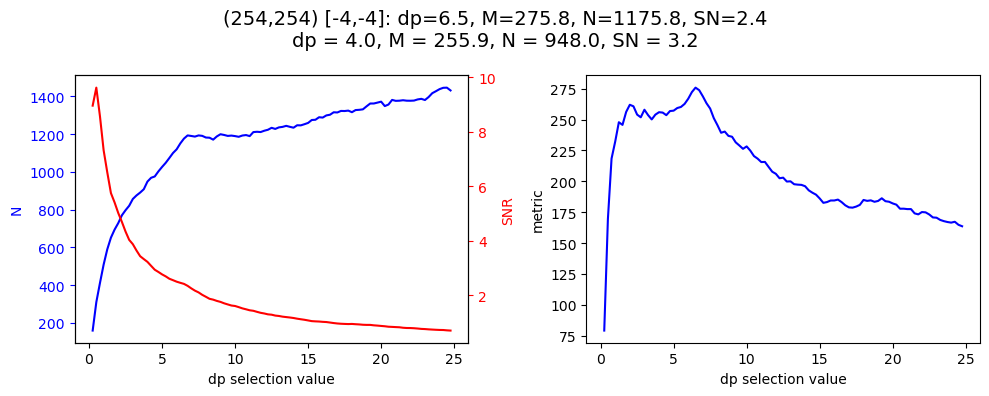

---> Working on (254,255) [-4,-3]


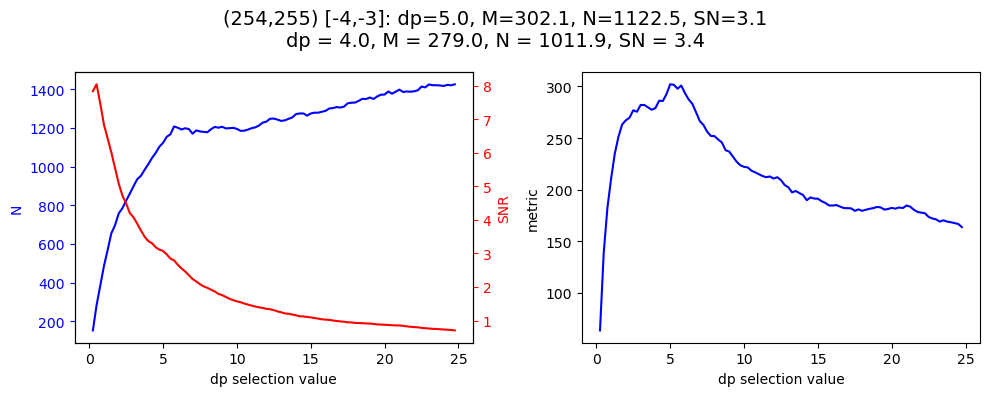

---> Working on (254,256) [-4,-2]


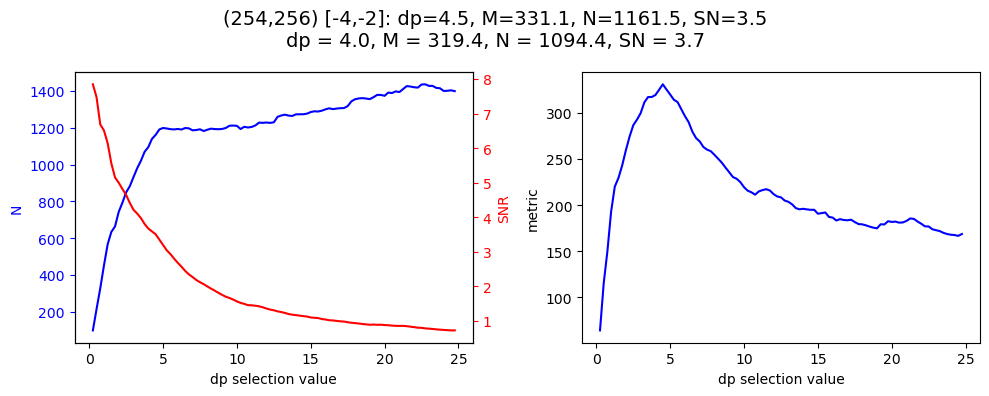

---> Working on (254,257) [-4,-1]


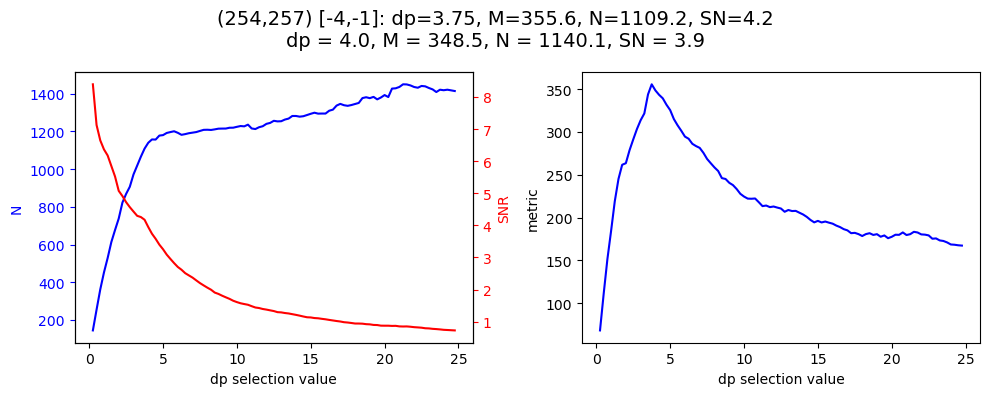

---> Working on (254,258) [-4,0]


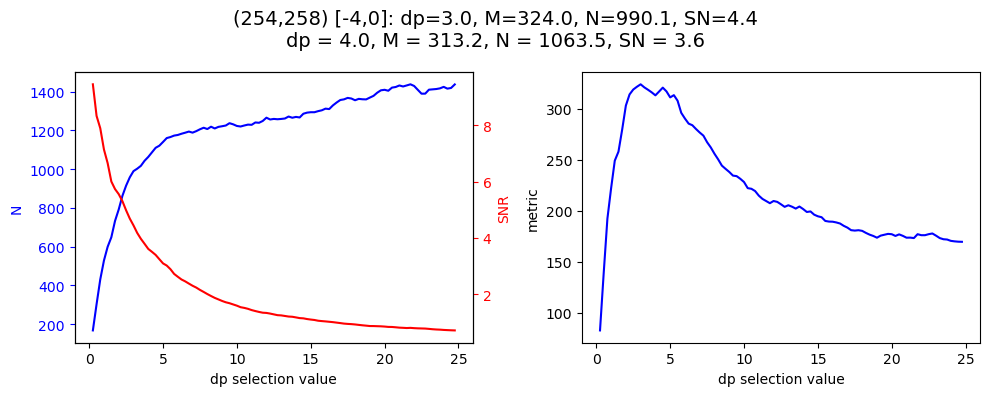

---> Working on (254,259) [-4,1]


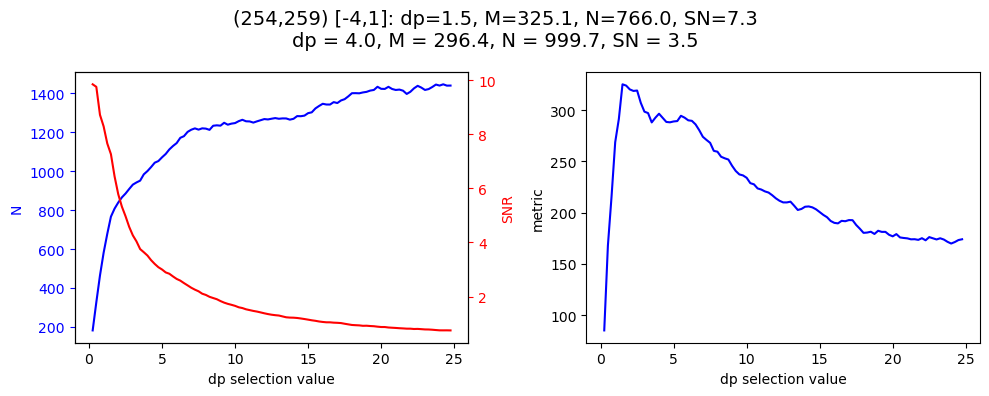

---> Working on (254,260) [-4,2]


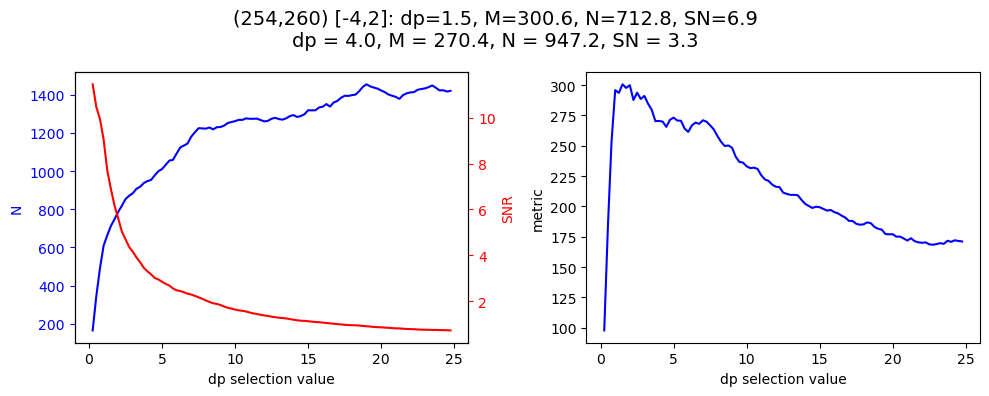

---> Working on (254,261) [-4,3]


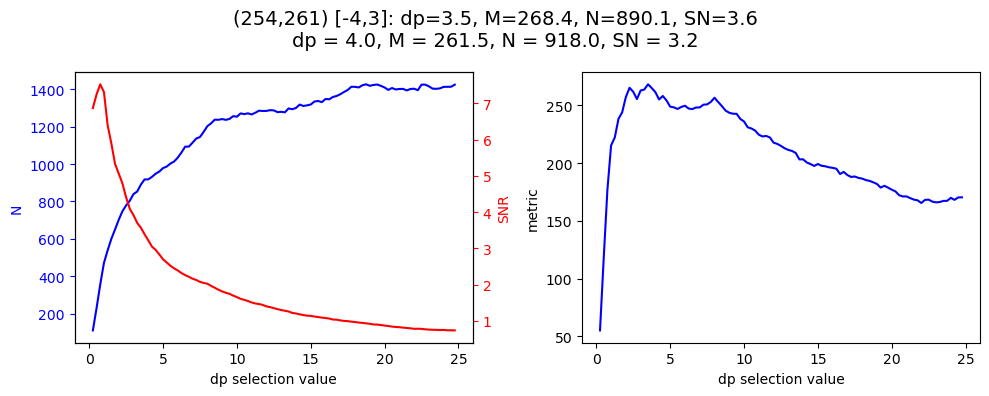

---> Working on (254,262) [-4,4]


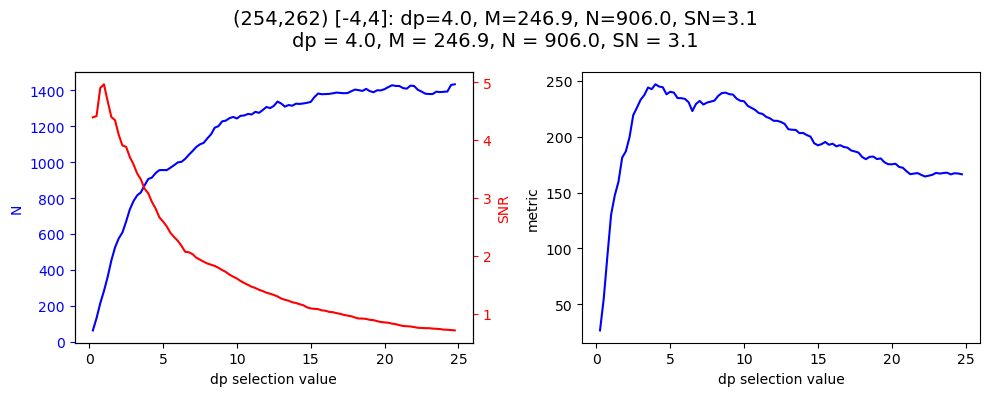

---> Working on (255,254) [-3,-4]


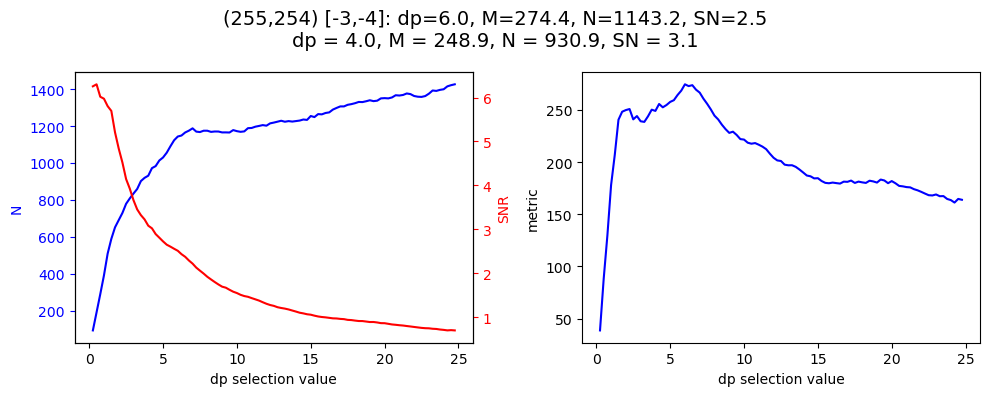

---> Working on (255,255) [-3,-3]


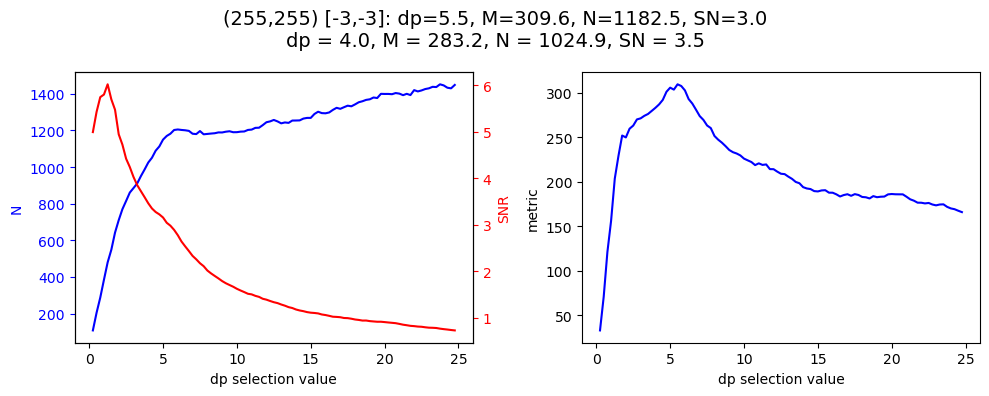

---> Working on (255,256) [-3,-2]


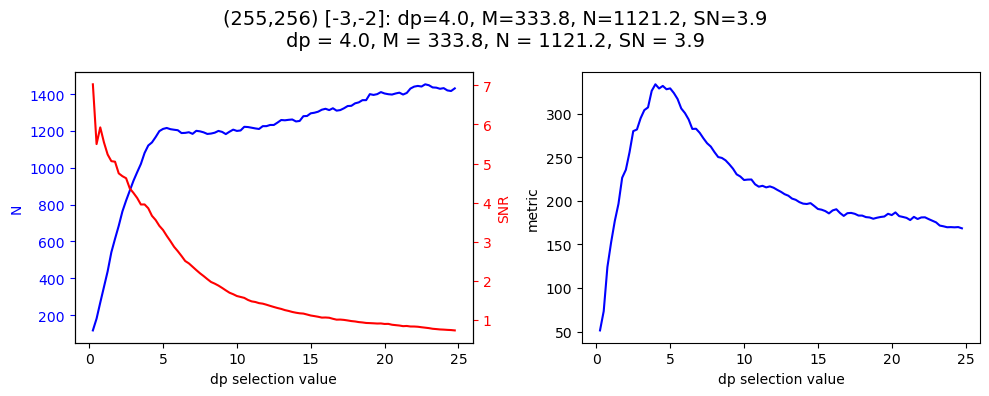

---> Working on (255,257) [-3,-1]


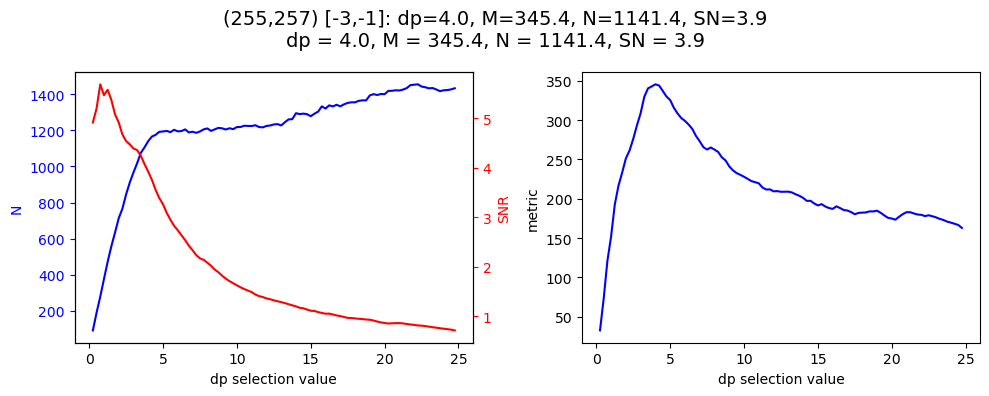

---> Working on (255,258) [-3,0]


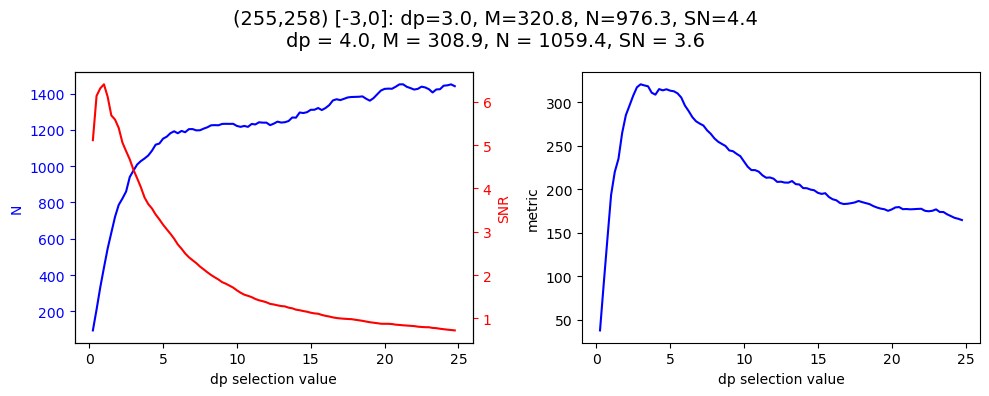

---> Working on (255,259) [-3,1]


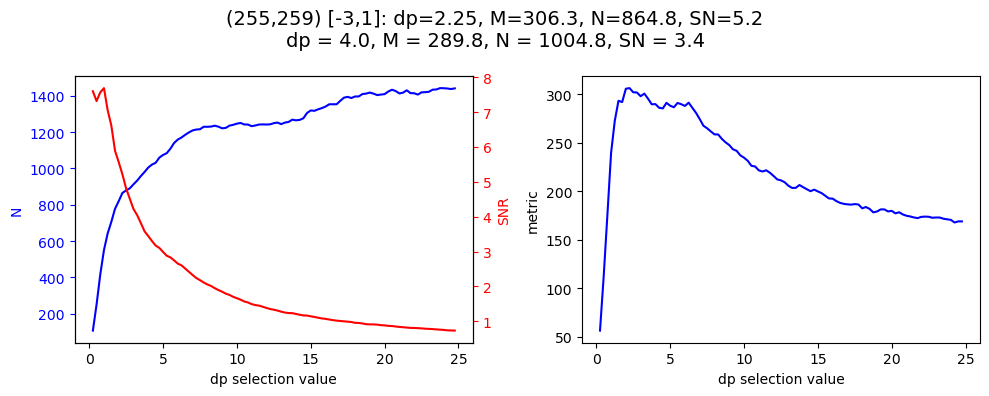

---> Working on (255,260) [-3,2]


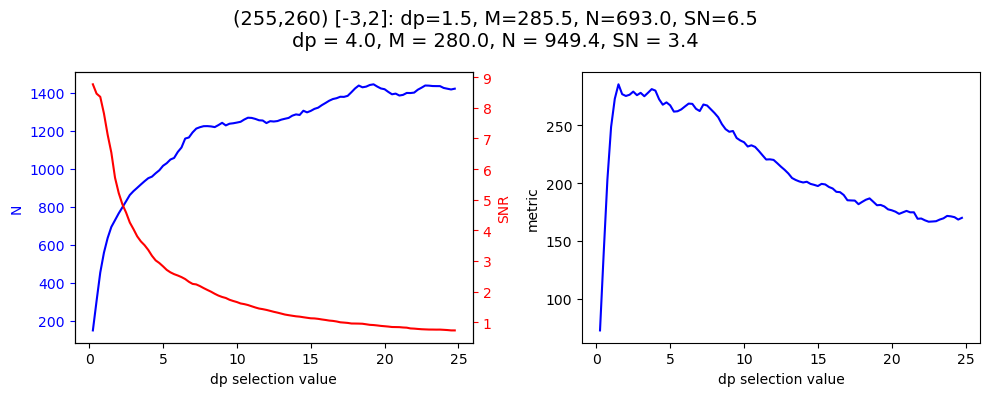

---> Working on (255,261) [-3,3]


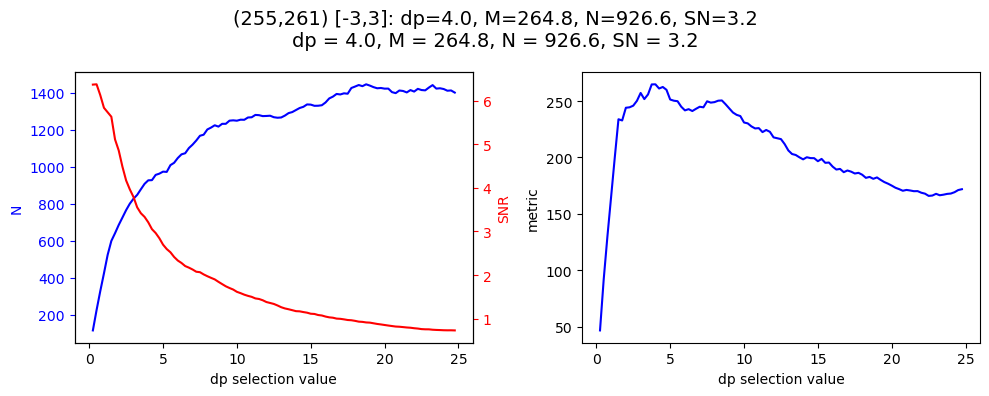

---> Working on (255,262) [-3,4]


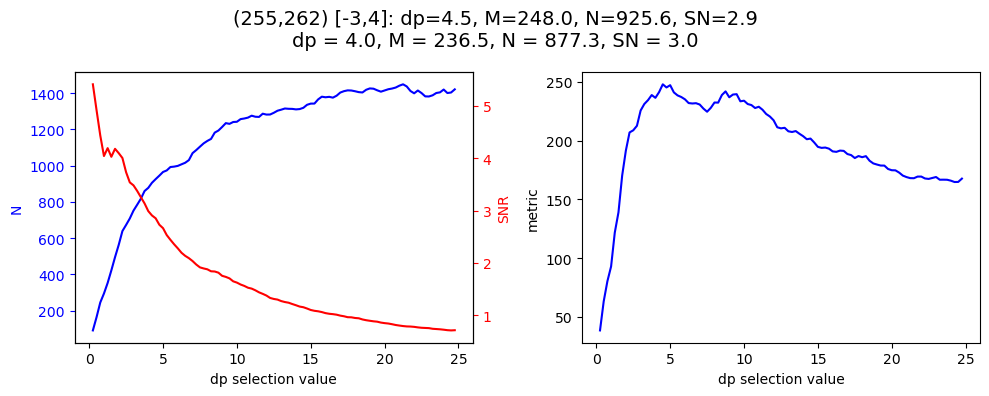

---> Working on (256,254) [-2,-4]


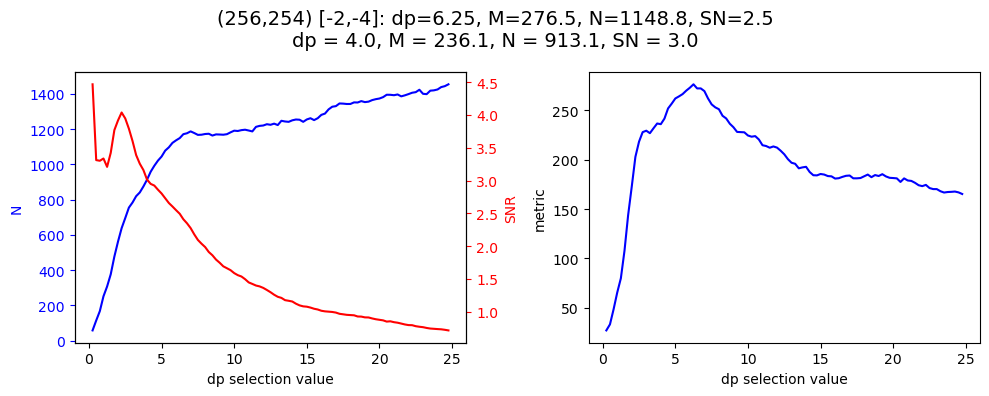

---> Working on (256,255) [-2,-3]


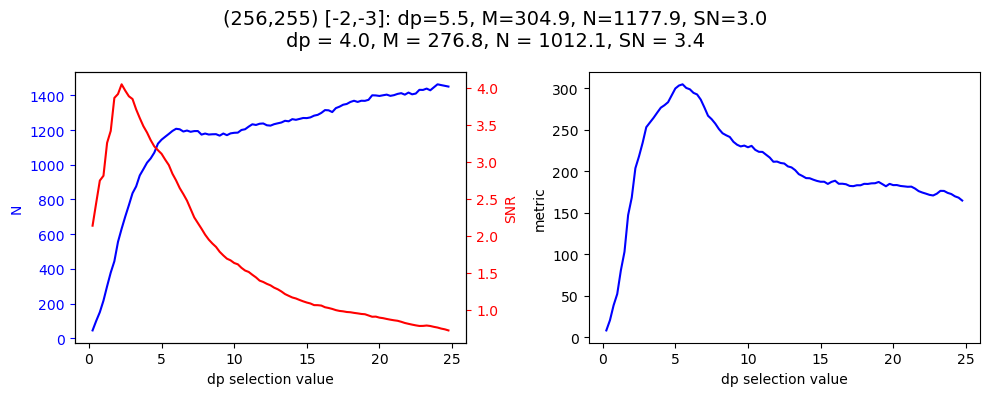

---> Working on (256,256) [-2,-2]


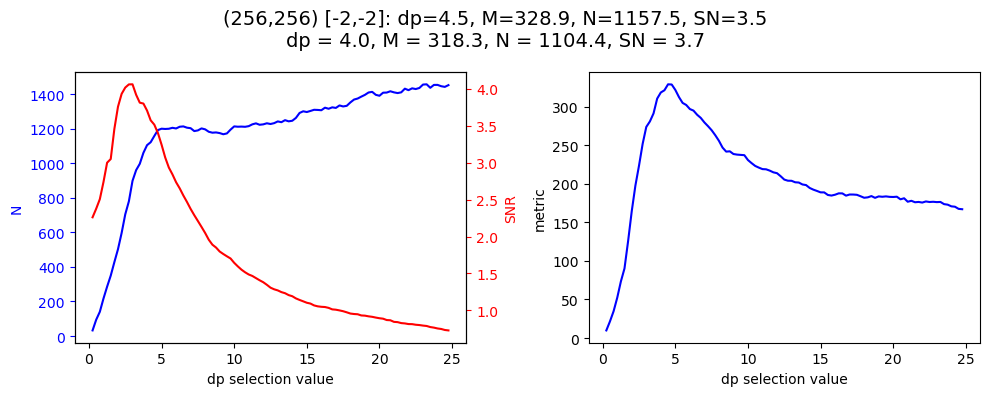

---> Working on (256,257) [-2,-1]


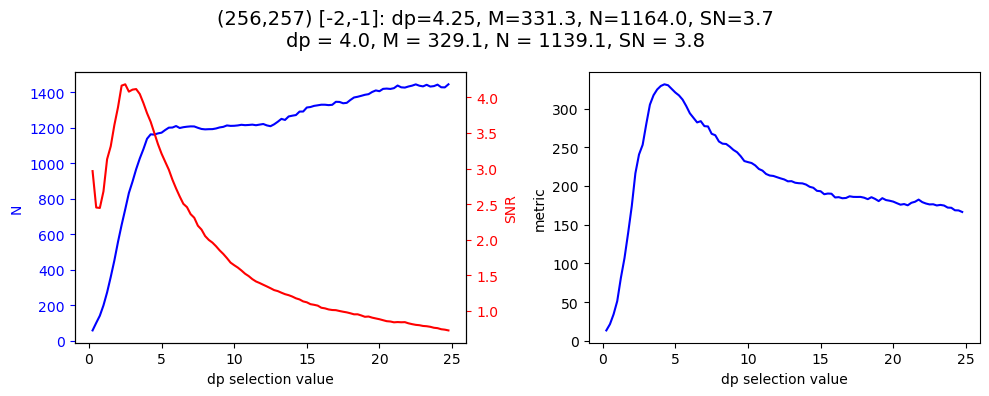

---> Working on (256,258) [-2,0]


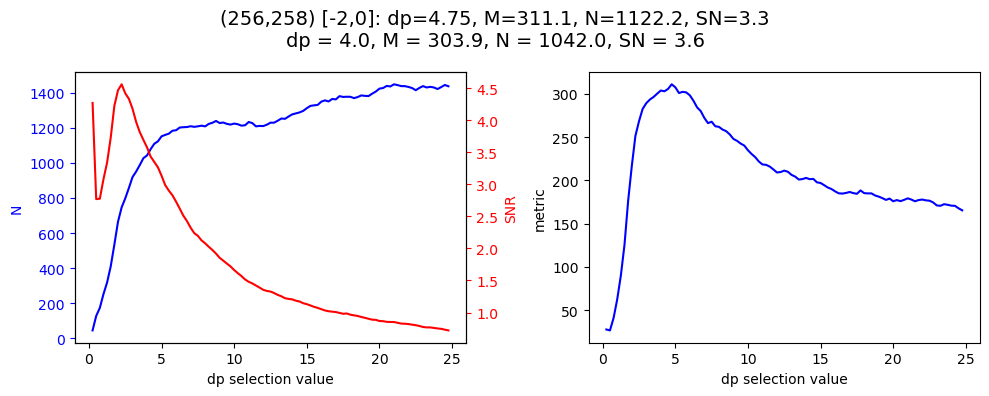

---> Working on (256,259) [-2,1]


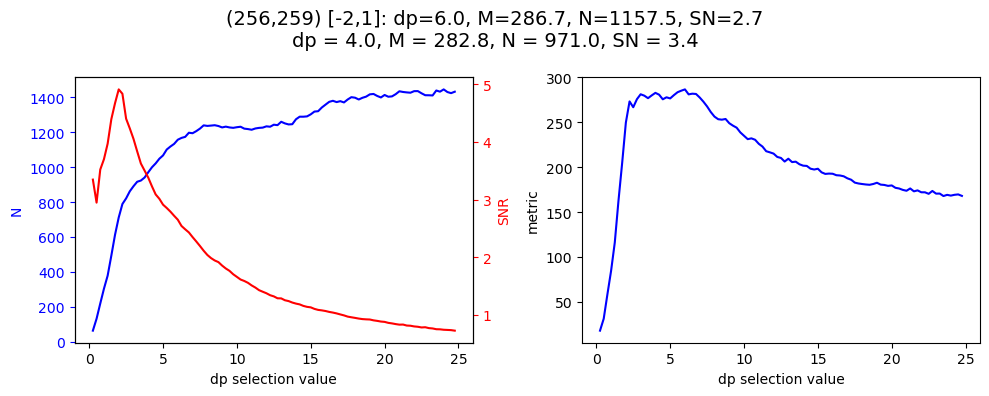

---> Working on (256,260) [-2,2]


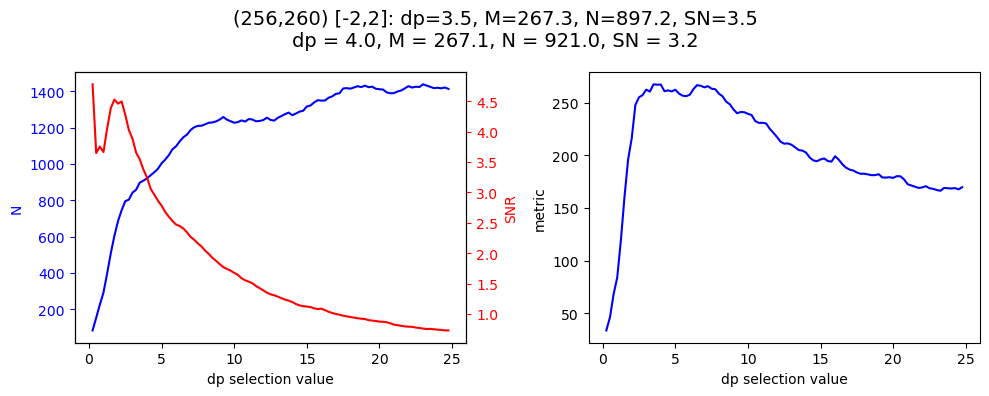

---> Working on (256,261) [-2,3]


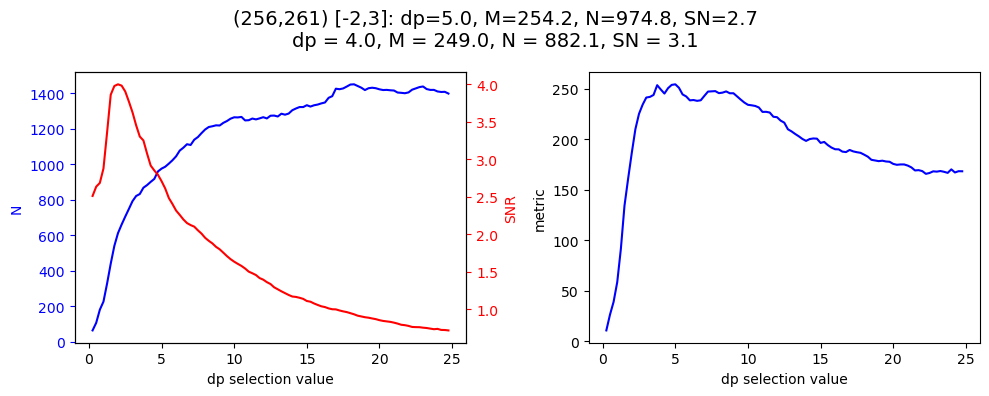

---> Working on (256,262) [-2,4]


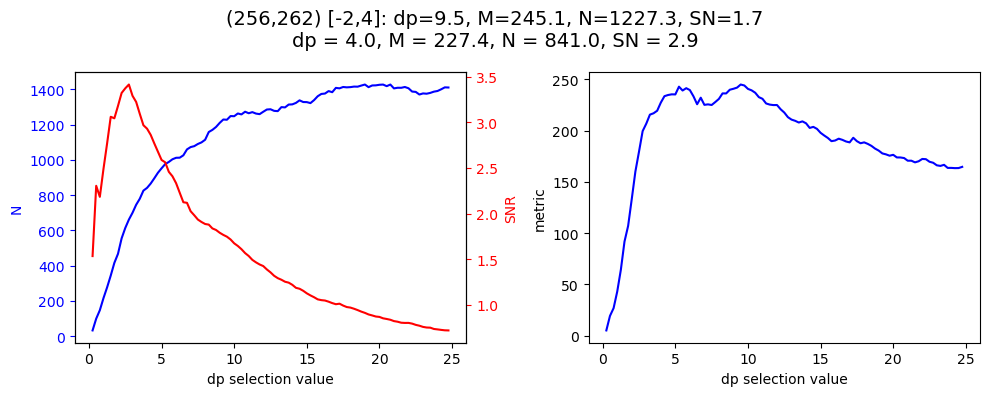

---> Working on (257,254) [-1,-4]


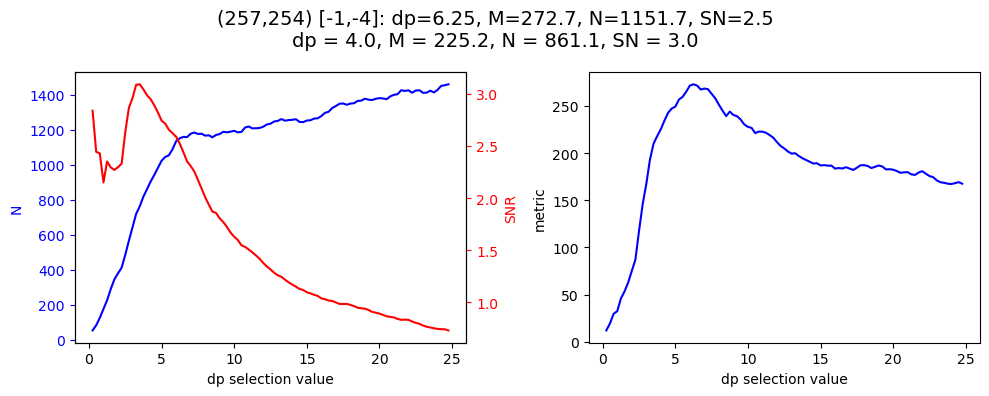

---> Working on (257,255) [-1,-3]


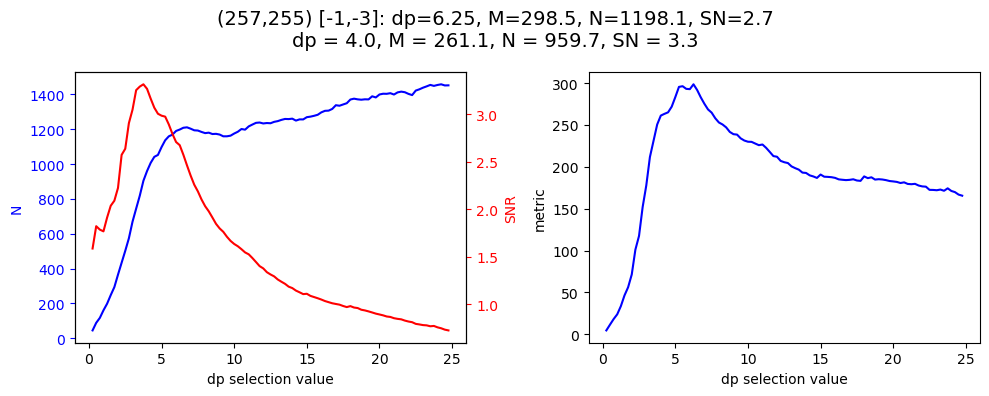

---> Working on (257,256) [-1,-2]


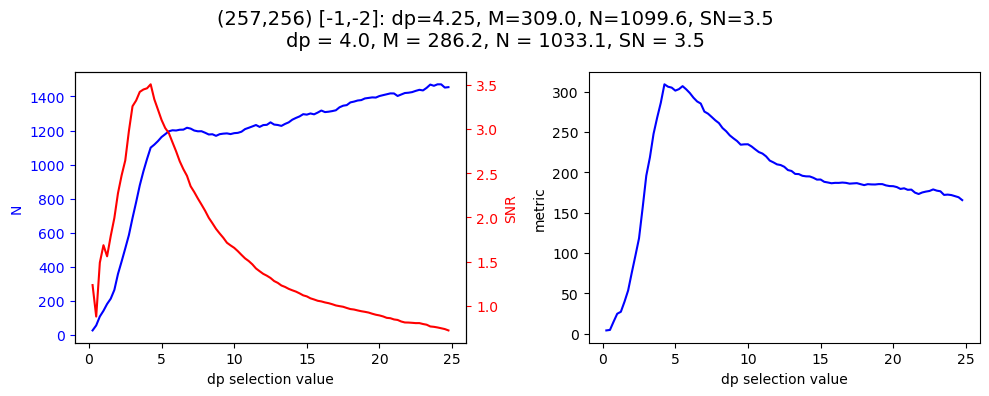

---> Working on (257,257) [-1,-1]


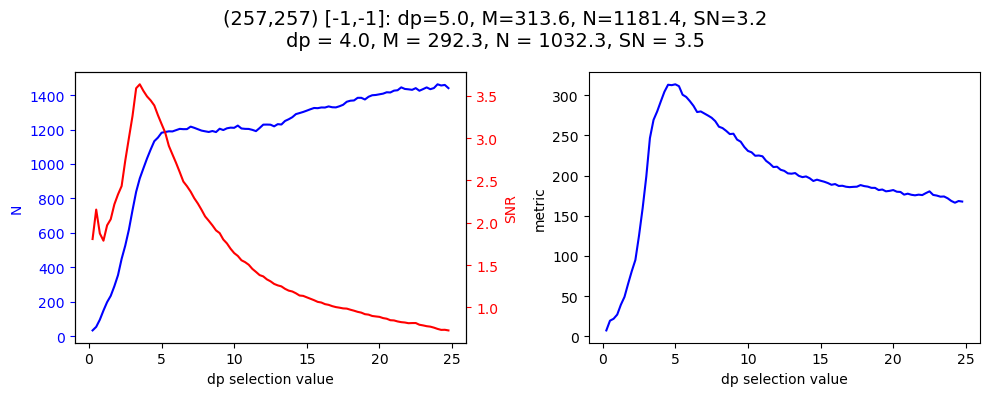

---> Working on (257,258) [-1,0]


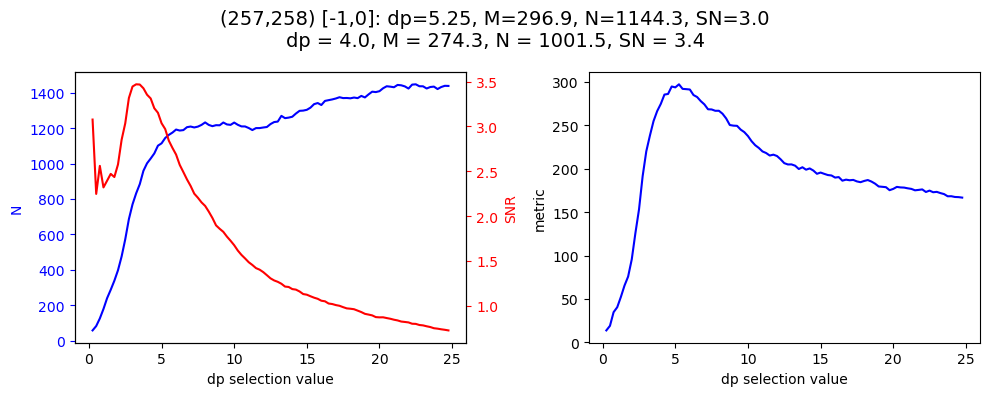

---> Working on (257,259) [-1,1]


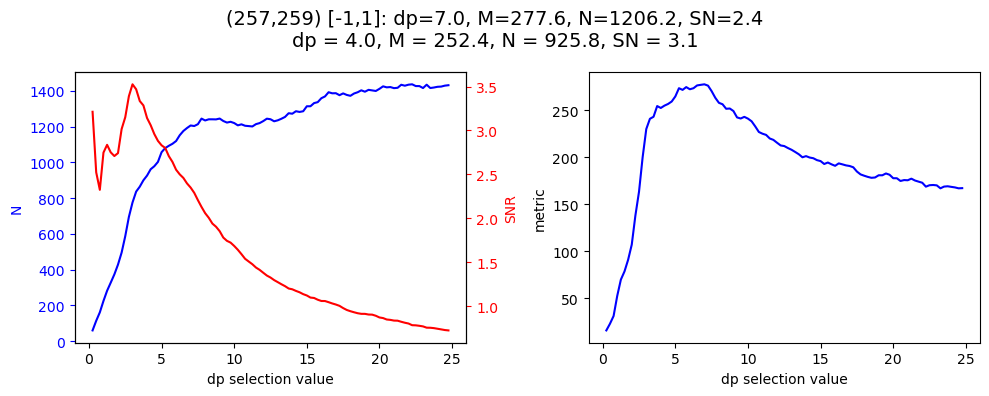

---> Working on (257,260) [-1,2]


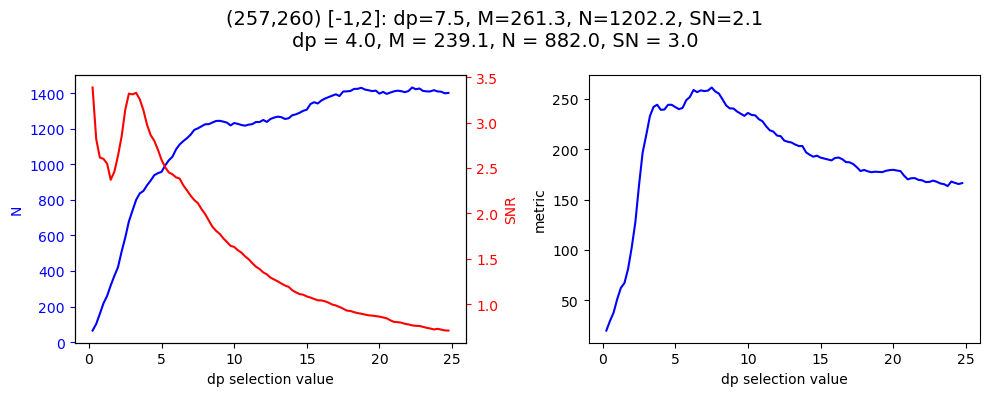

---> Working on (257,261) [-1,3]


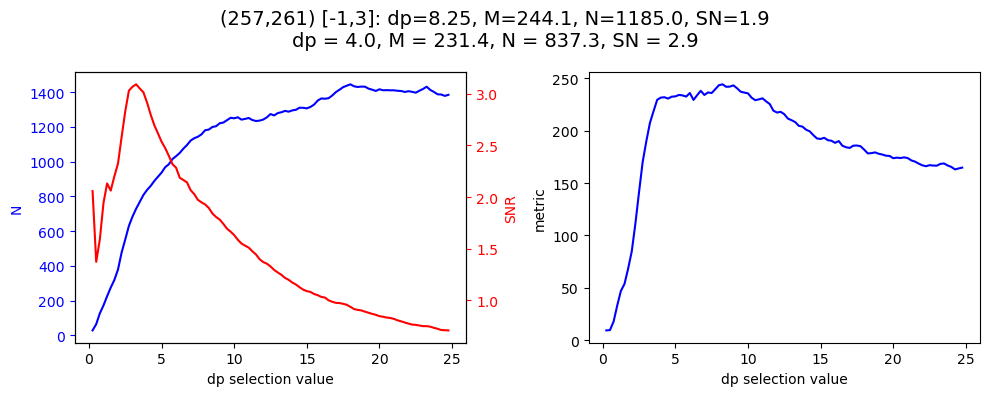

---> Working on (257,262) [-1,4]


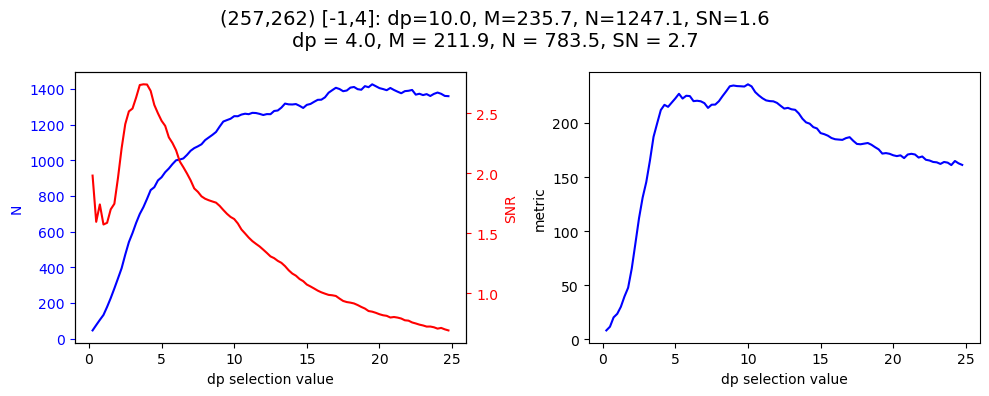

---> Working on (258,254) [0,-4]


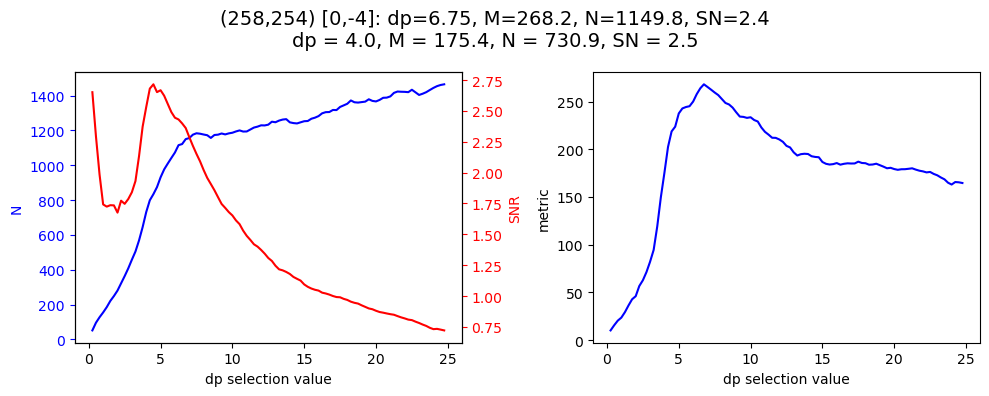

---> Working on (258,255) [0,-3]


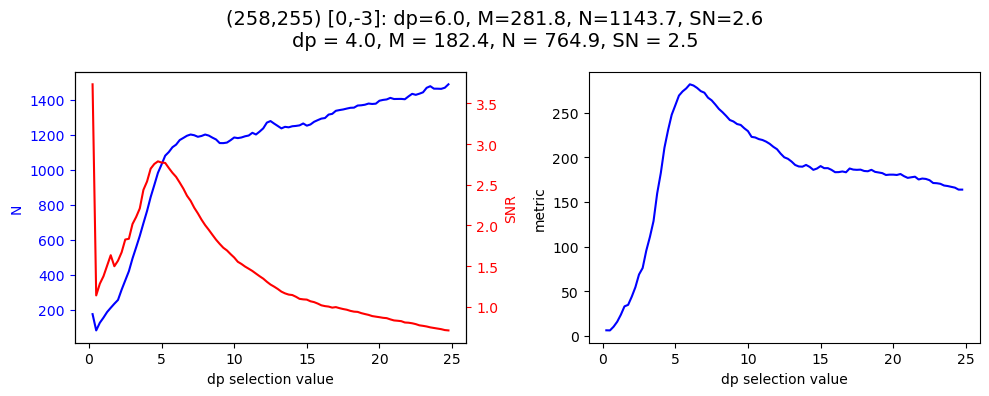

---> Working on (258,256) [0,-2]


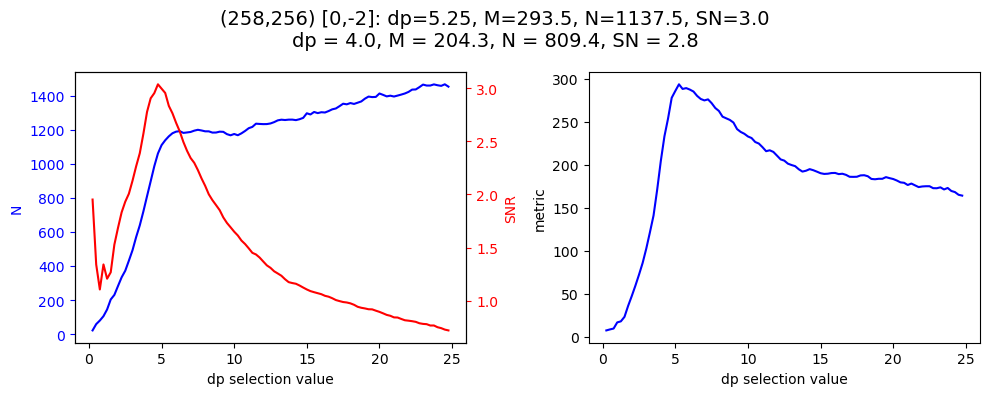

---> Working on (258,257) [0,-1]


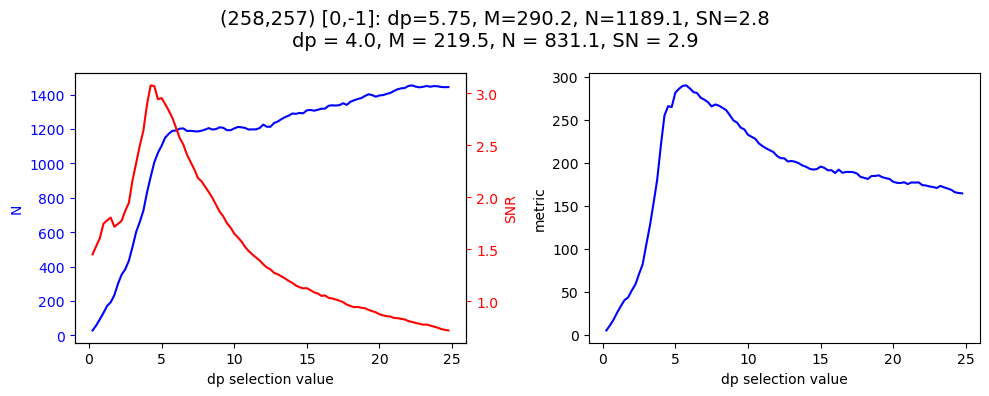

---> Working on (258,258) [0,0]


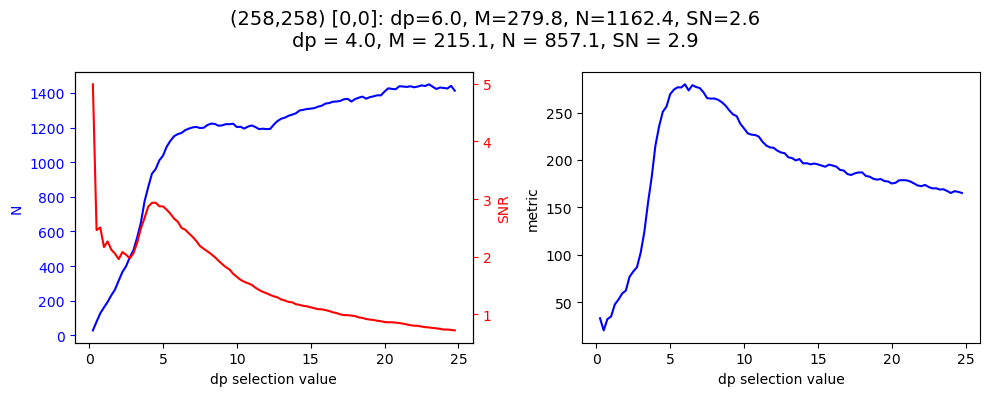

---> Working on (258,259) [0,1]


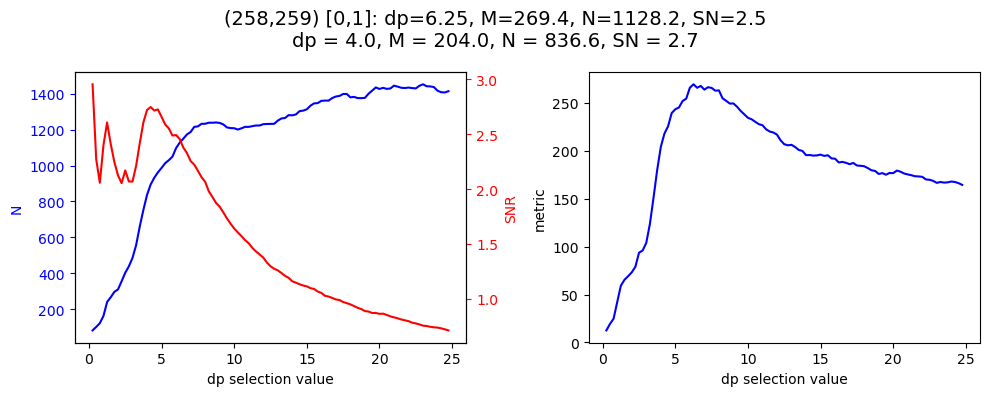

---> Working on (258,260) [0,2]


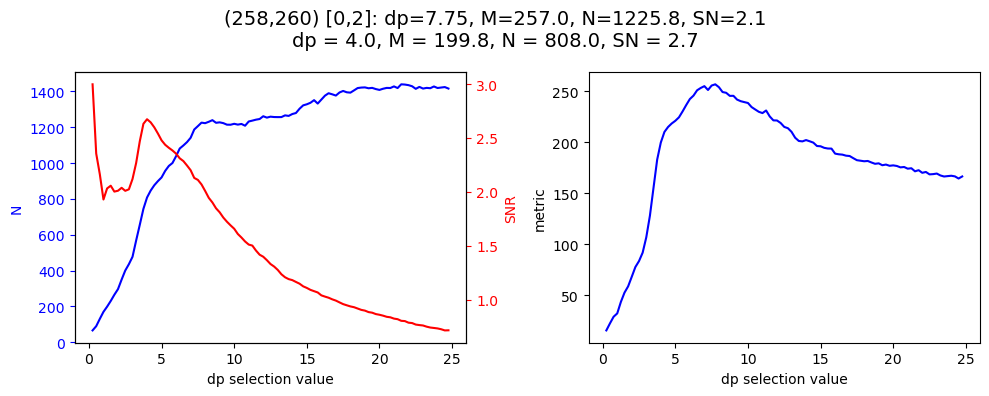

---> Working on (258,261) [0,3]


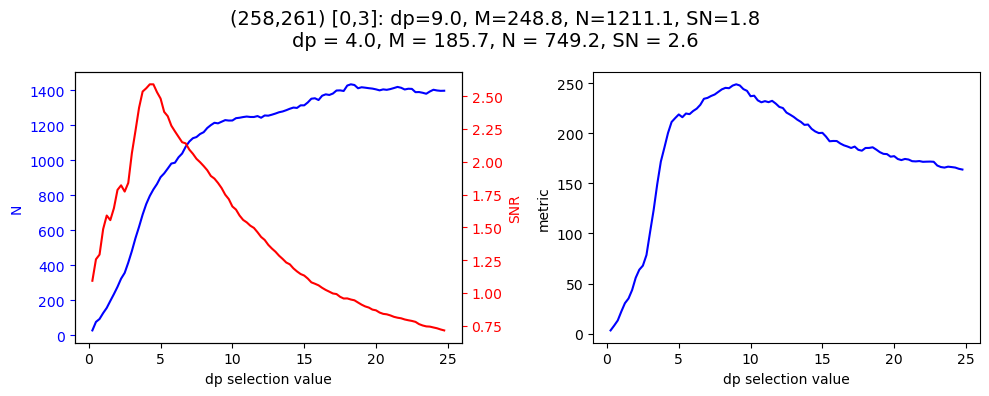

---> Working on (258,262) [0,4]


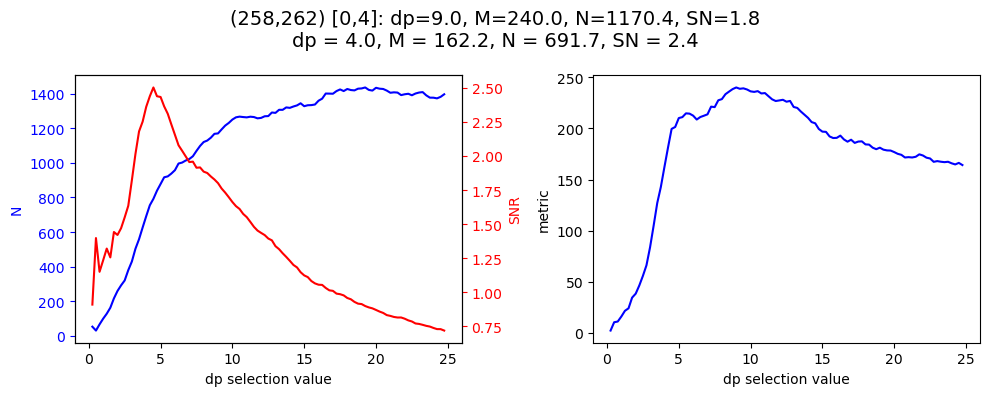

---> Working on (259,254) [1,-4]


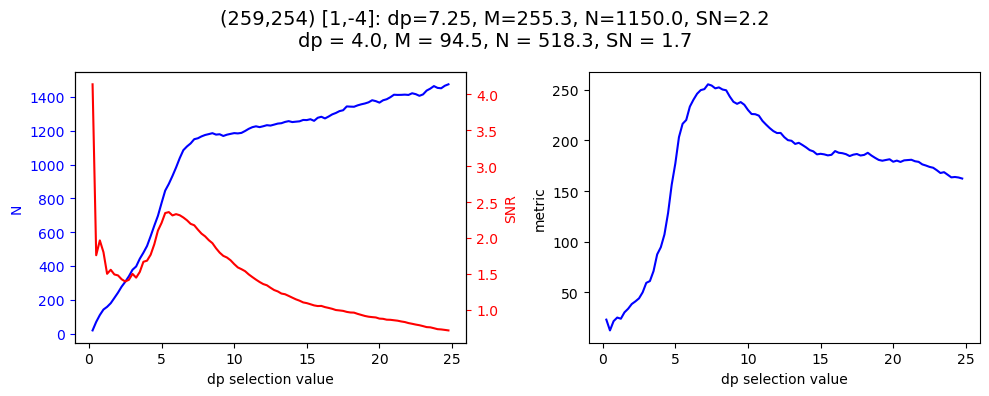

---> Working on (259,255) [1,-3]


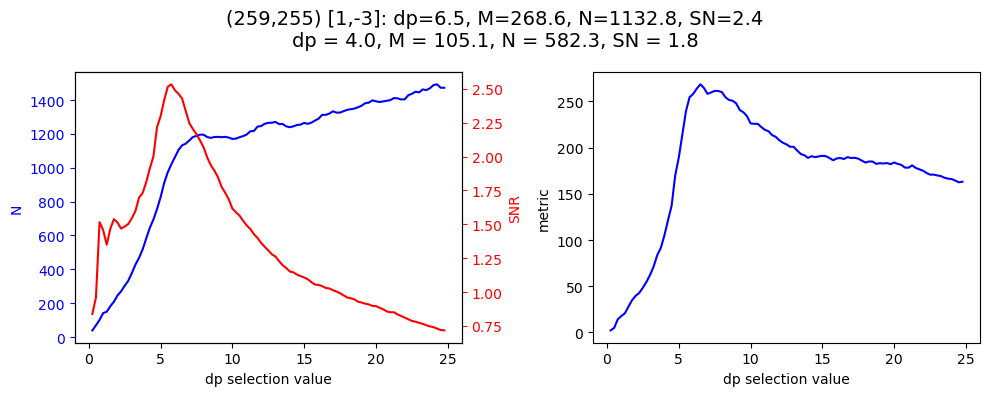

---> Working on (259,256) [1,-2]


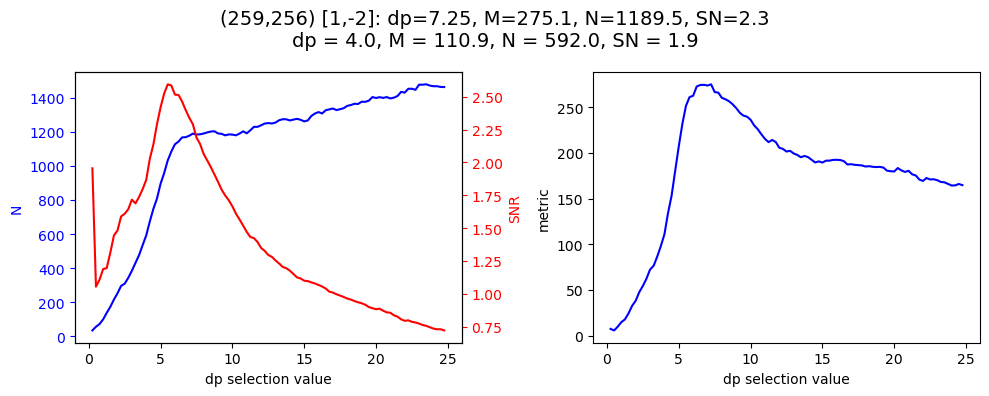

---> Working on (259,257) [1,-1]


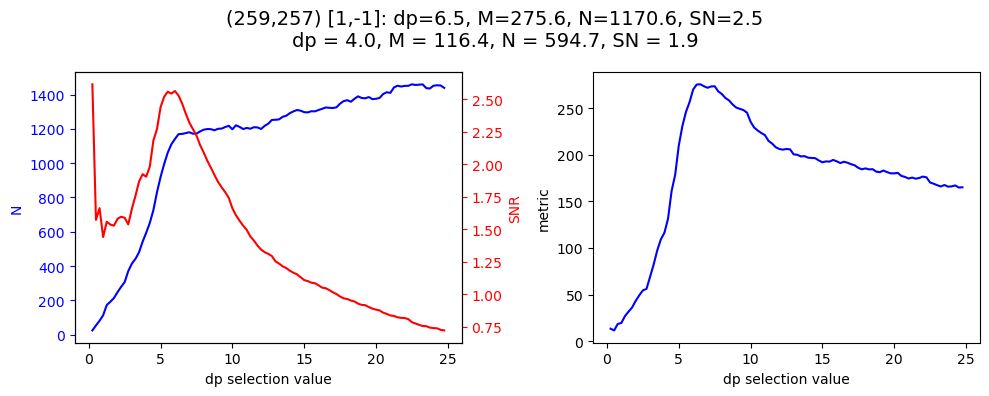

---> Working on (259,258) [1,0]


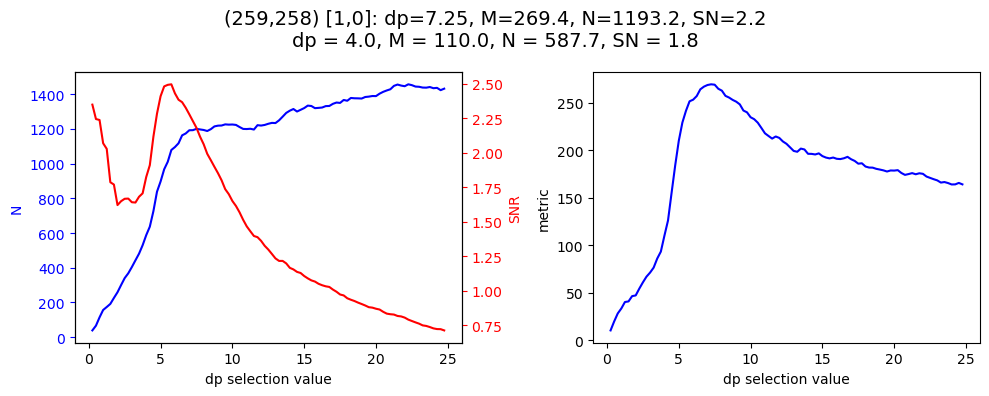

---> Working on (259,259) [1,1]


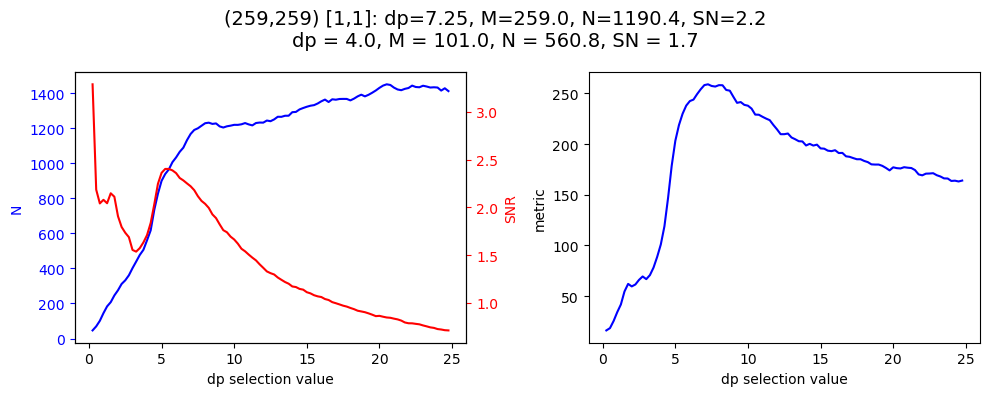

---> Working on (259,260) [1,2]


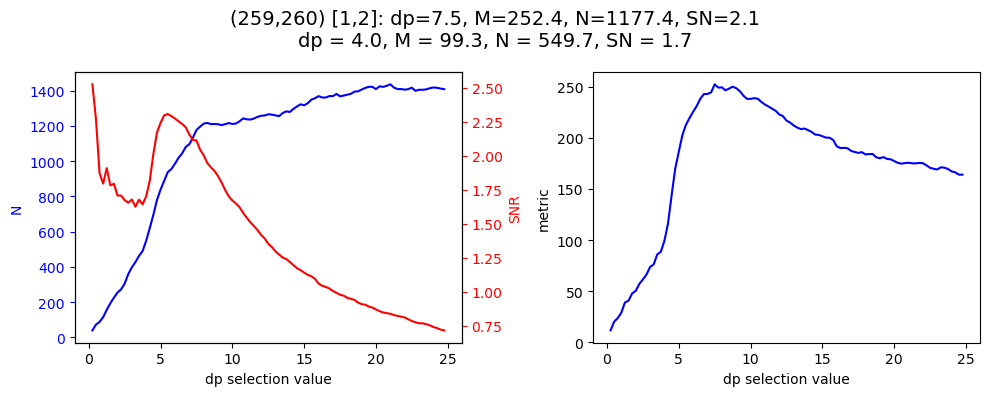

---> Working on (259,261) [1,3]


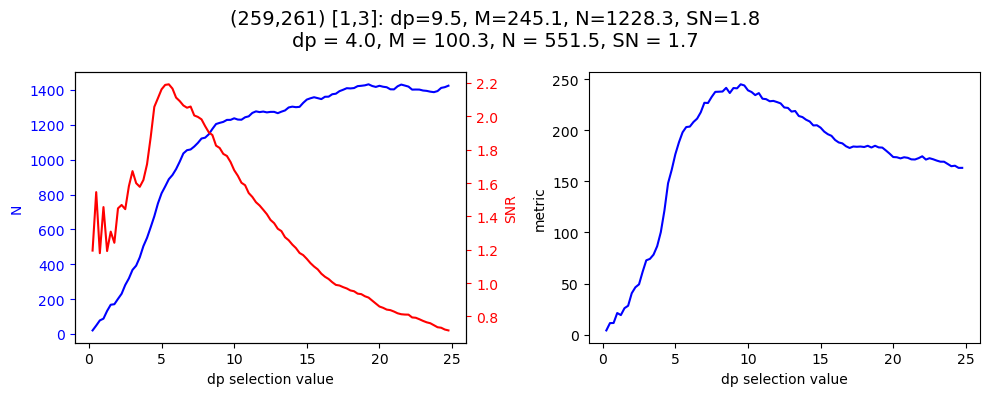

---> Working on (259,262) [1,4]


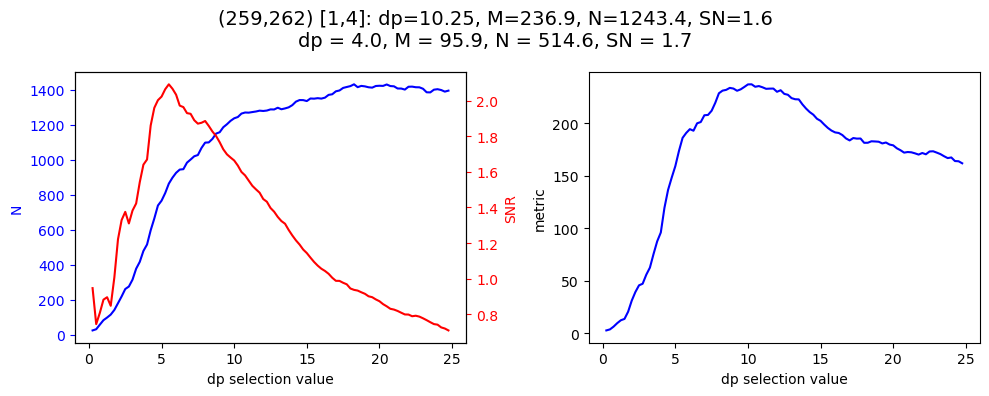

---> Working on (260,254) [2,-4]


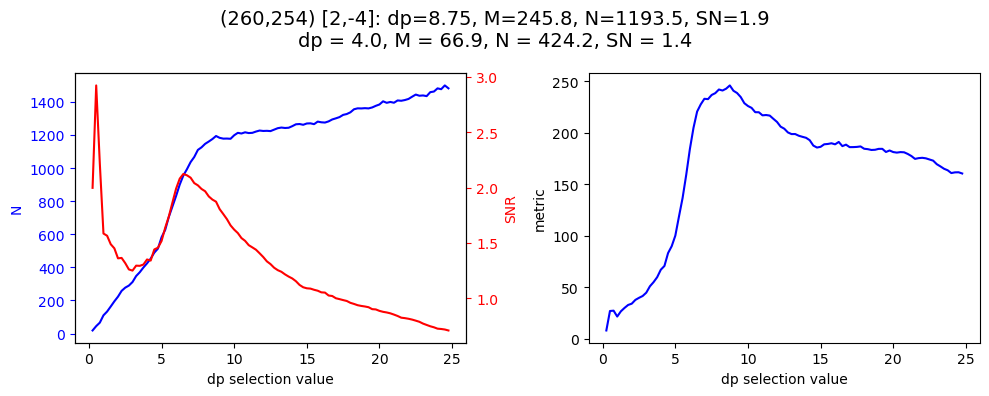

---> Working on (260,255) [2,-3]


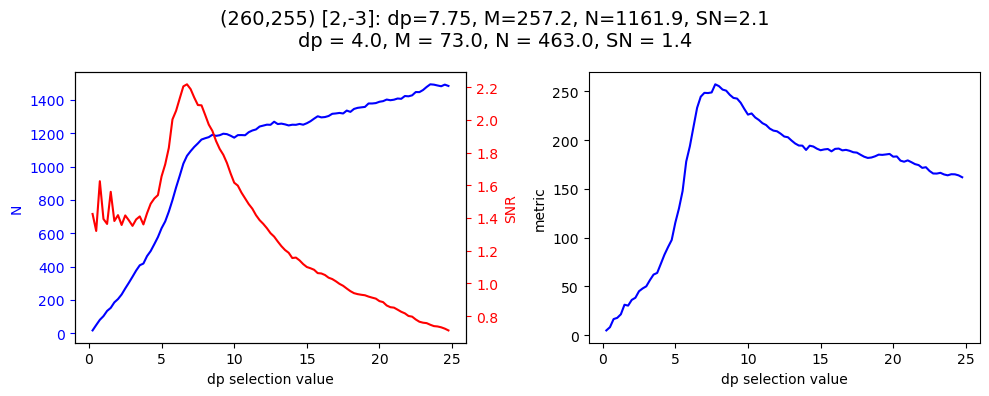

---> Working on (260,256) [2,-2]


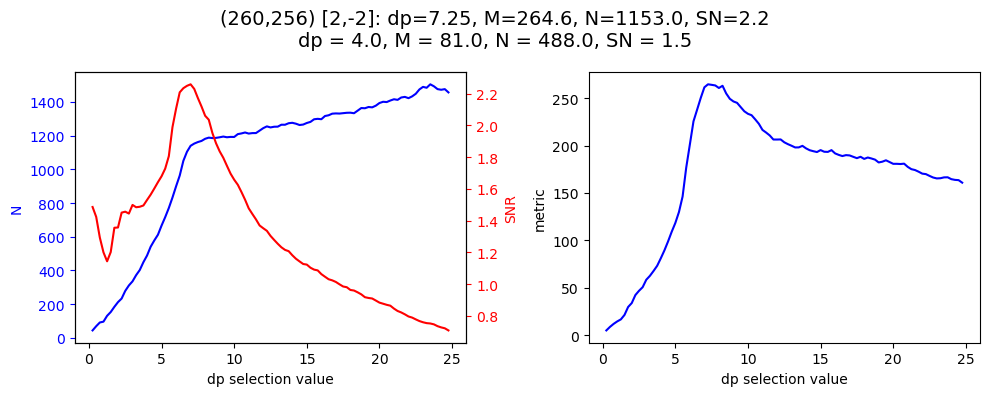

---> Working on (260,257) [2,-1]


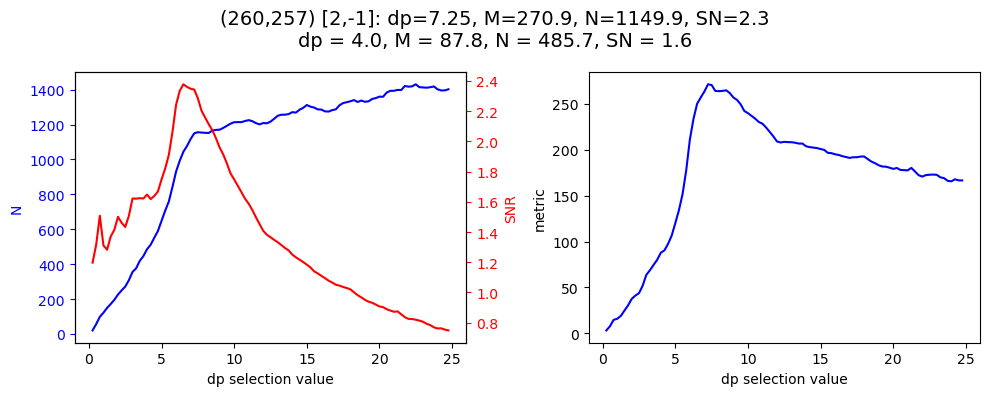

---> Working on (260,258) [2,0]


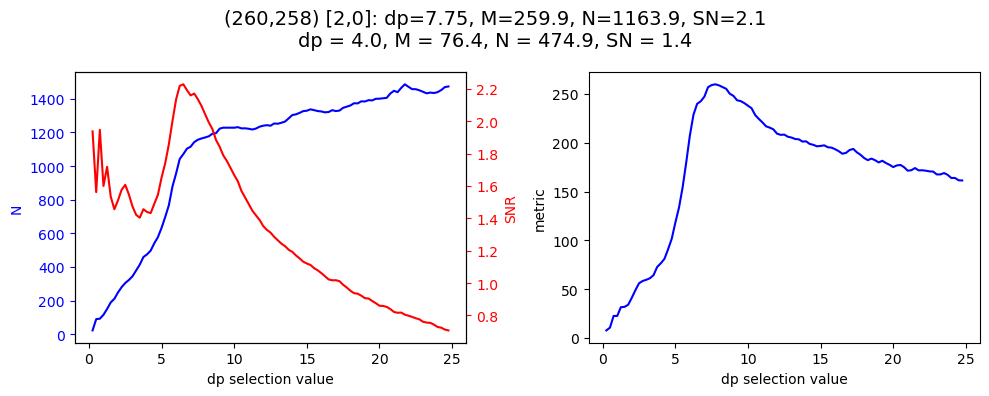

---> Working on (260,259) [2,1]


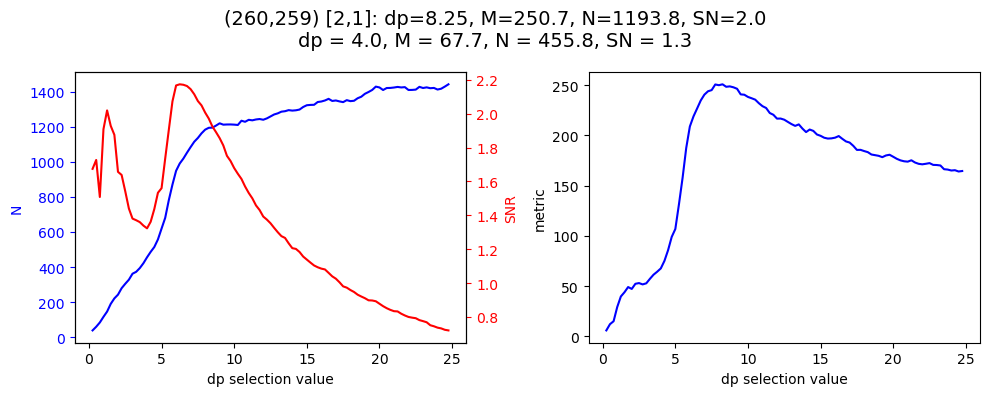

---> Working on (260,260) [2,2]


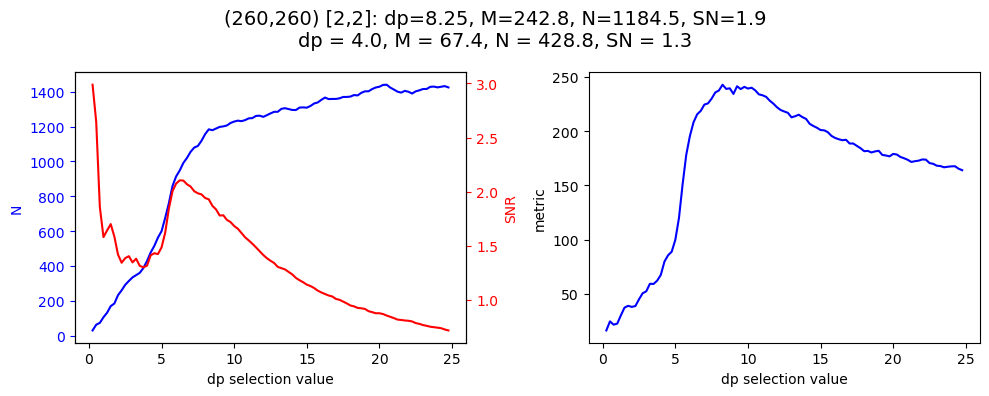

---> Working on (260,261) [2,3]


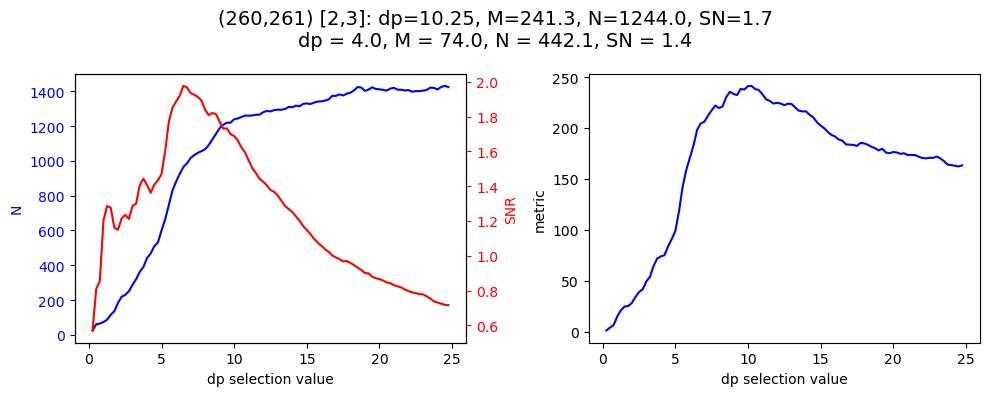

---> Working on (260,262) [2,4]


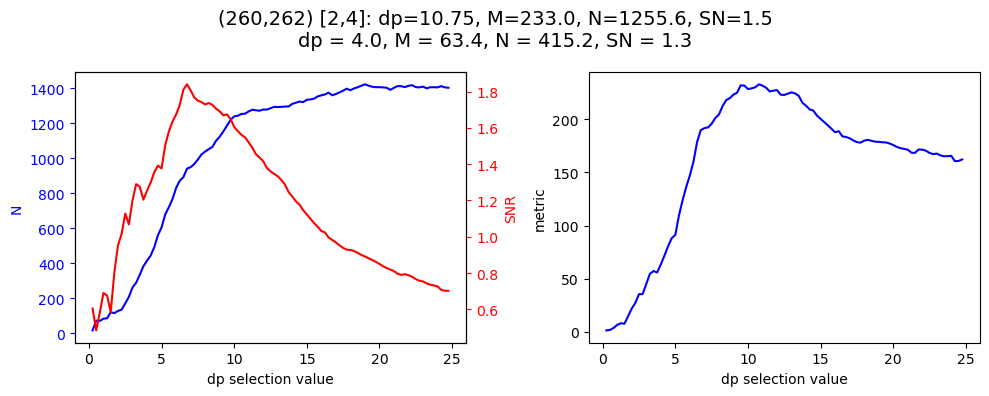

---> Working on (261,254) [3,-4]


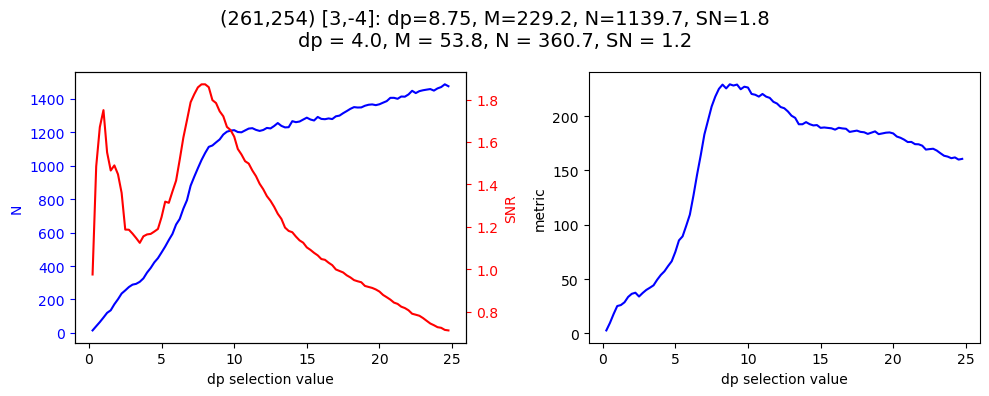

---> Working on (261,255) [3,-3]


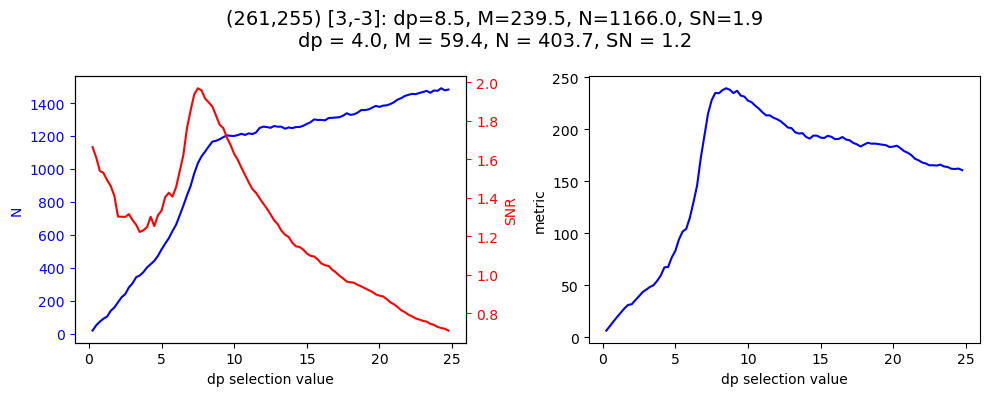

---> Working on (261,256) [3,-2]


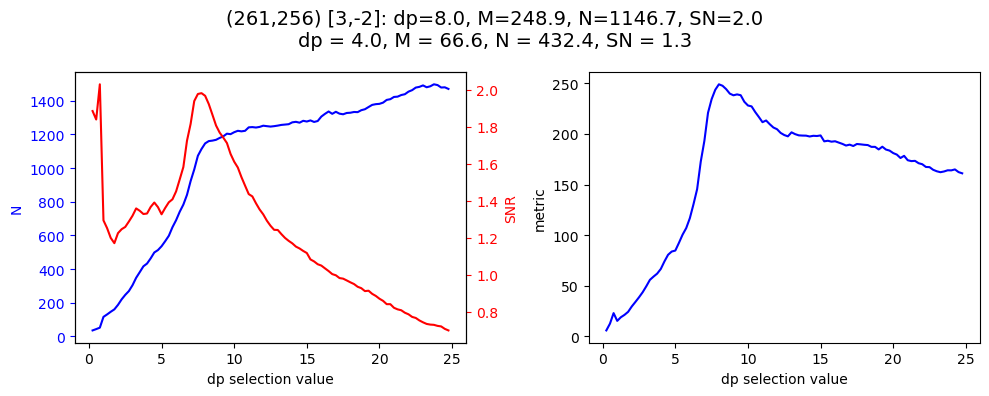

---> Working on (261,257) [3,-1]


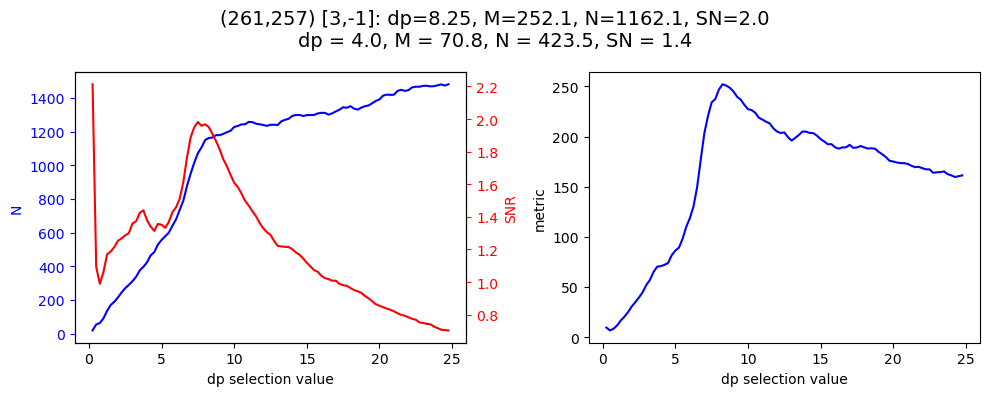

---> Working on (261,258) [3,0]


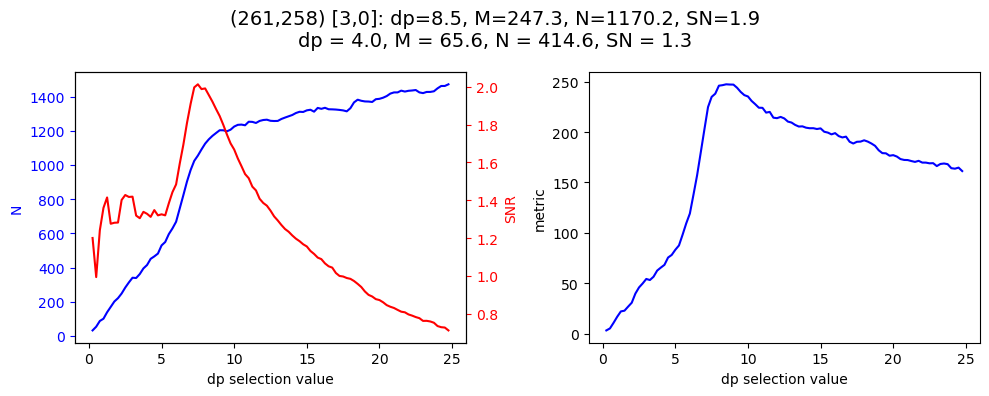

---> Working on (261,259) [3,1]


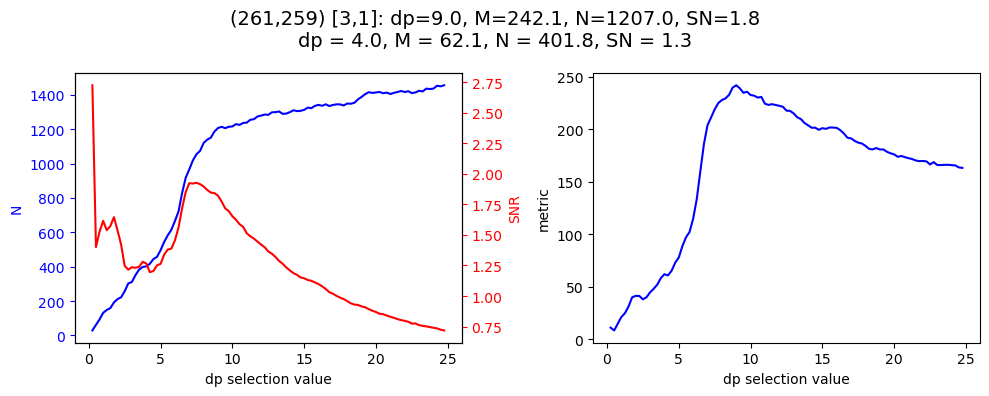

---> Working on (261,260) [3,2]


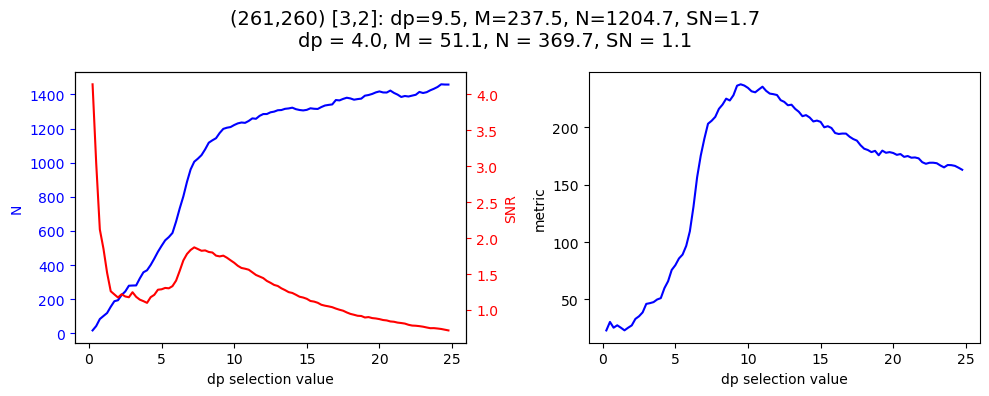

---> Working on (261,261) [3,3]


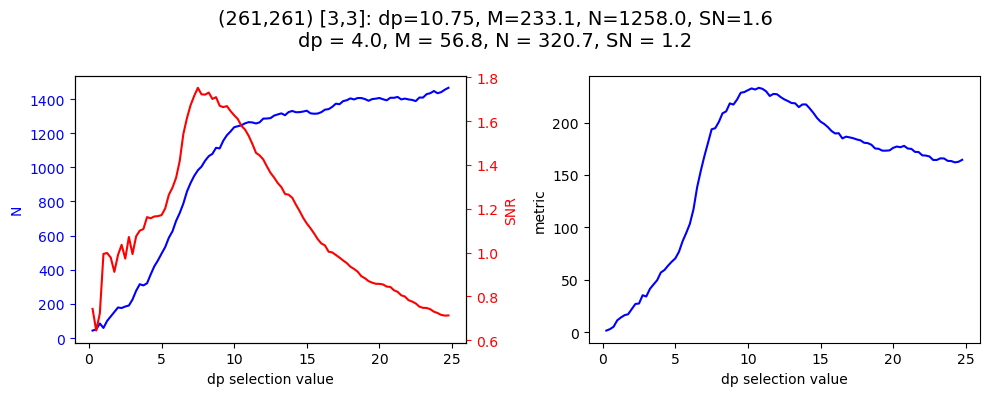

---> Working on (261,262) [3,4]


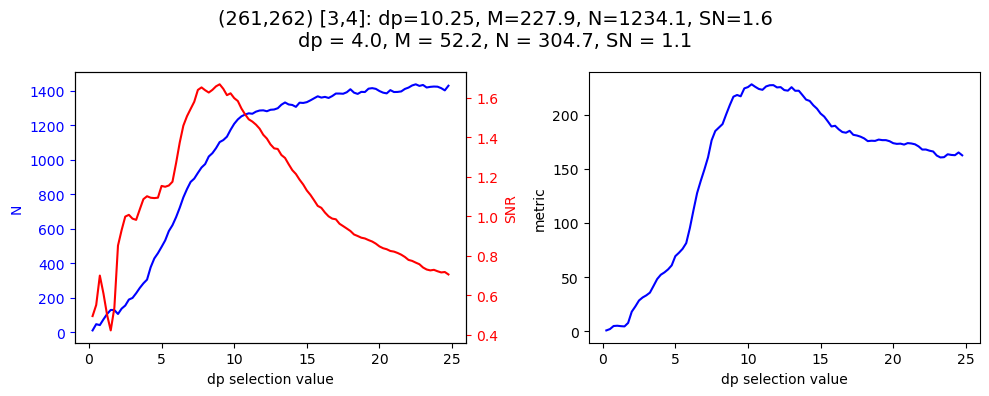

---> Working on (262,254) [4,-4]


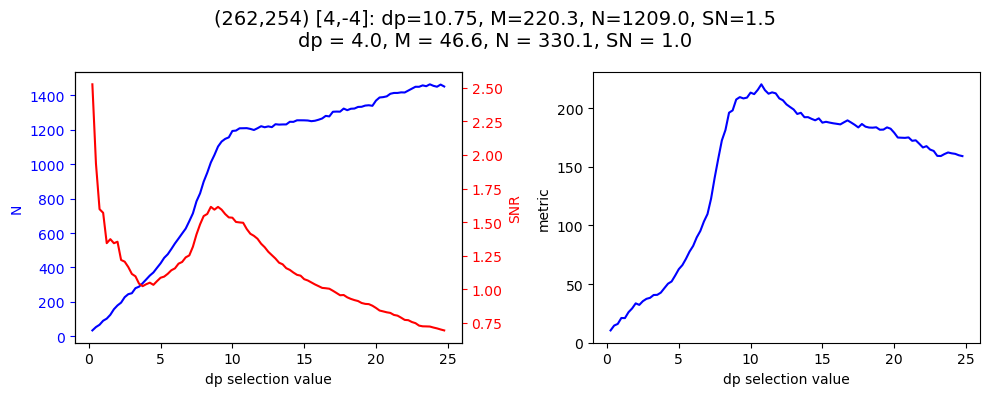

---> Working on (262,255) [4,-3]


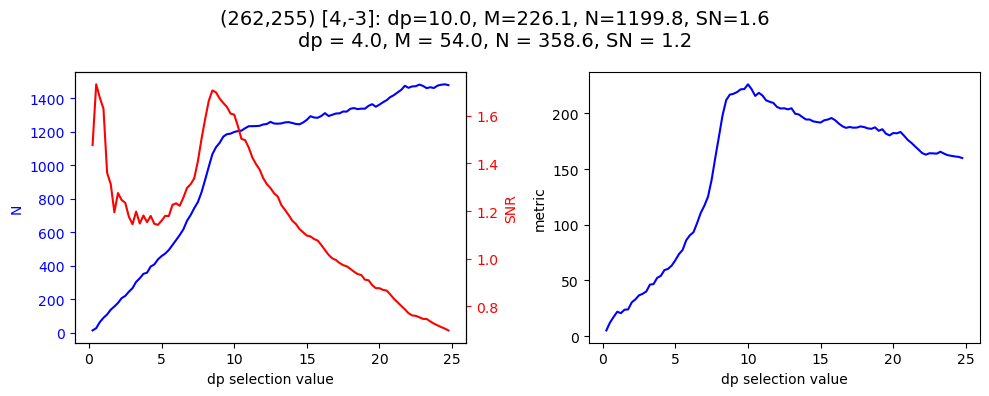

---> Working on (262,256) [4,-2]


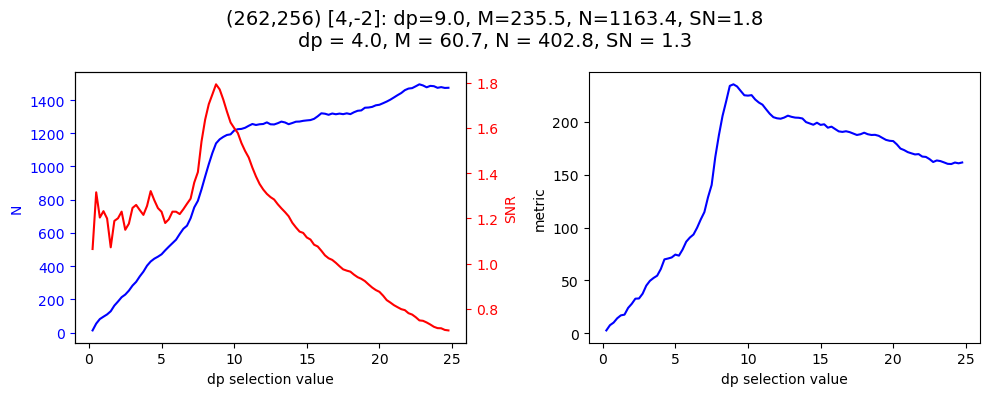

---> Working on (262,257) [4,-1]


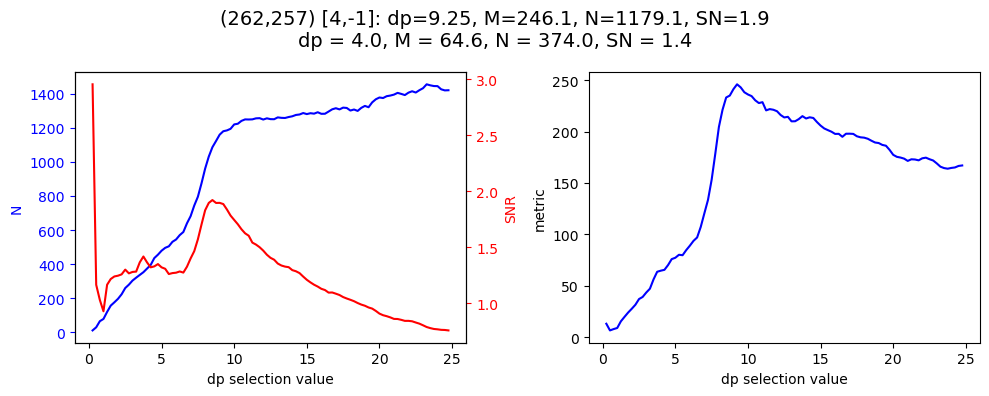

---> Working on (262,258) [4,0]


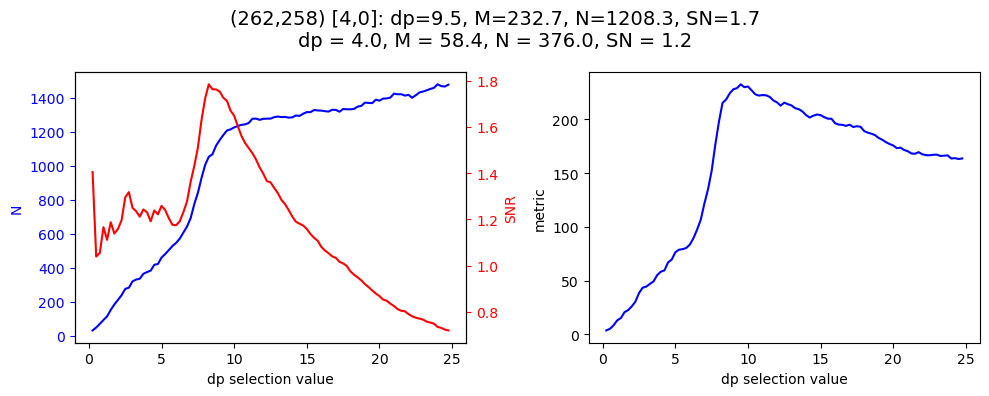

---> Working on (262,259) [4,1]


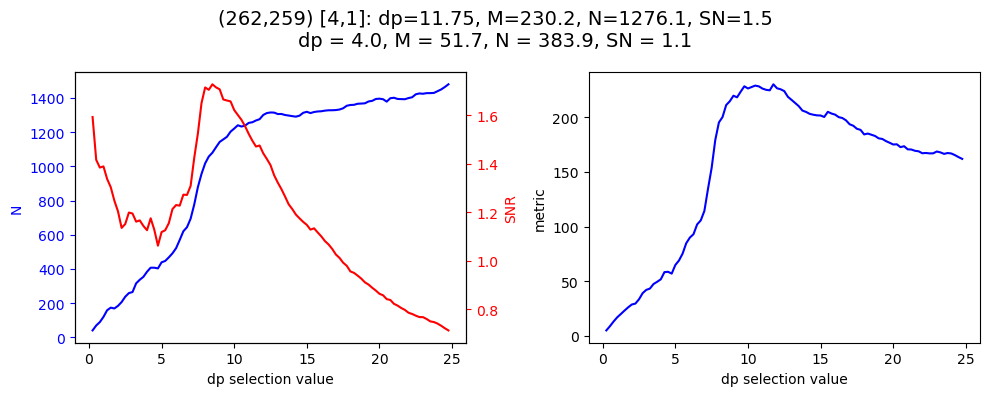

---> Working on (262,260) [4,2]


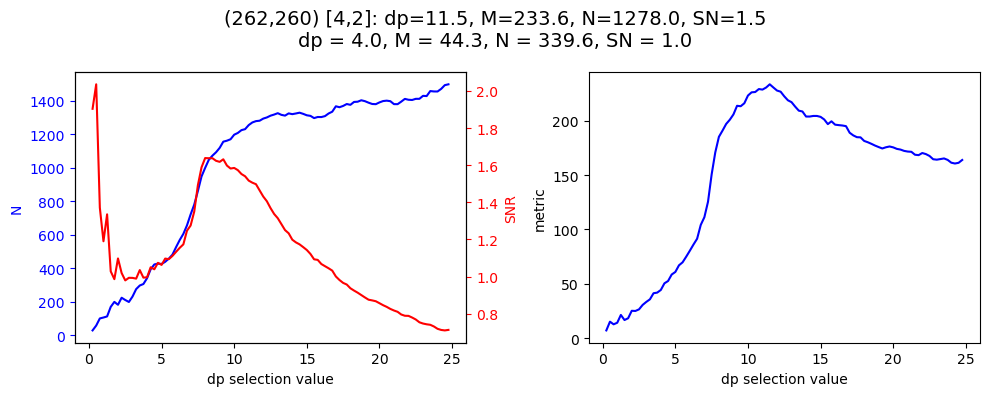

---> Working on (262,261) [4,3]


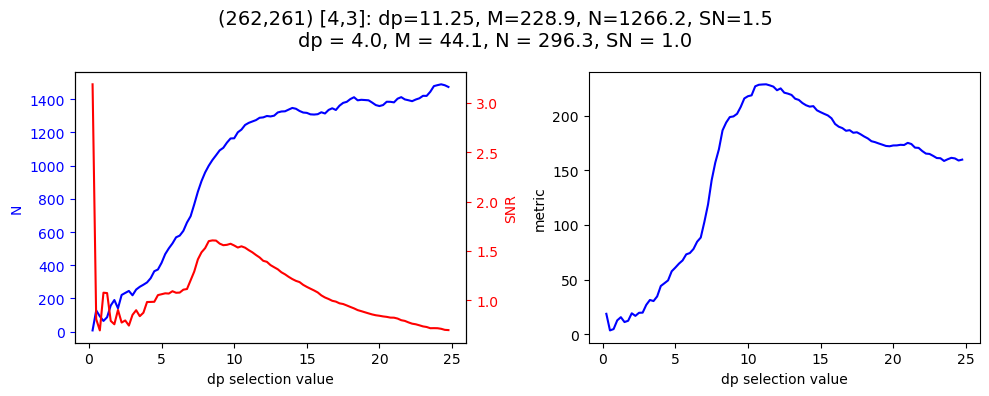

---> Working on (262,262) [4,4]


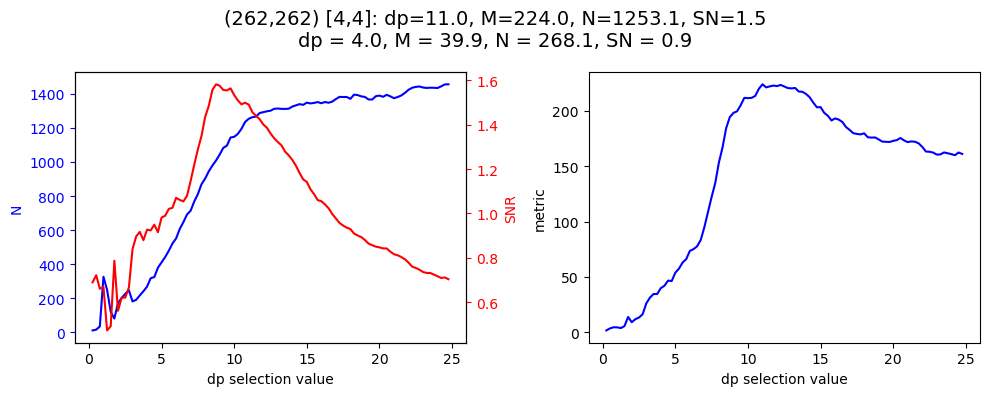

In [9]:
### Analysis of dp selection value and center location.
dp_search = True
if dp_search:
    coords = [[i, j] for i in range(scan_info['x_cen'] + x_minus_offset, scan_info['x_cen'] + x_plus_offset + 1) for j in range(scan_info['y_cen'] + y_minus_offset, scan_info['y_cen'] + y_plus_offset + 1)]
    dp_lists = ts.dp_search(df_pairs, scan_info, coords)

In [10]:
update_pos = True

best_metric_pos = np.nanargmax(dp_lists['best_metric'])
best_metric = dp_lists['best_metric'][best_metric_pos]
best_coord = dp_lists['coords'][best_metric_pos]
best_dp = dp_lists['best_dp'][best_metric_pos]
print("Best coordinate is most likely at {} with dp = {} pix and metric = {:.1f}".format(best_coord, best_dp, best_metric))
print("Set coordinate was [{}, {}]".format(scan_info['x_cen'], scan_info['y_cen']))

if update_pos:
    scan_info['x_cen'] = best_coord[0]
    scan_info['y_cen'] = best_coord[1]

Best coordinate is most likely at [254, 257] with dp = 3.75 pix and metric = 355.6
Set coordinate was [258, 258]


On loop 0
--> df dt
p0_guess: [508.0, 0, 11.924264389558378, 985.81875]
A: 236.65009653117096
N: 6954.494037544624
x0: 1.8699653706034887
sigma: 72.35791441552512
const: 1885.8402094313965
SN: 0.12548788351613513
bin_size: 6.25


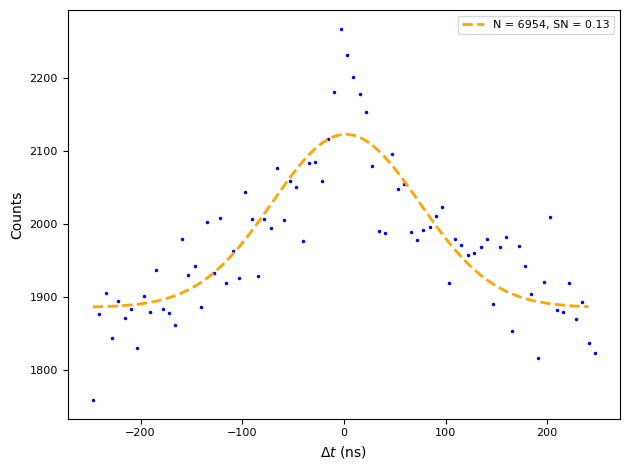


--> df dt Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 3290.154406790395
N: 6195.561294509312
x0_1: 15.474131100073542
sigma1: 2.6784168322885424
A2: 634.825959824675
x0_2: 12.166402720232183
sigma2: 0.9733657362881862
const: -5.754880109131565
bin_size: 0.25


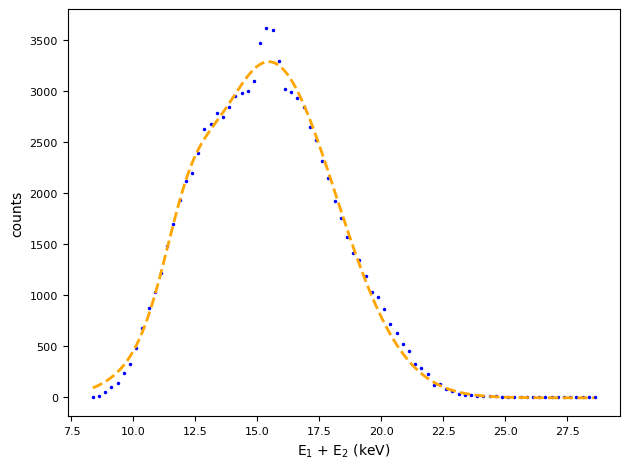


--> df dt Etot dp

--> df dt dp

--> df dt dp Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 471.54180781998423
N: 6167.358778897359
x0_1: 15.440191957870894
sigma1: 0.24345827131514167
A2: 184.28761190573766
x0_2: 15.830658513264517
sigma2: 3.337744938283755
const: -5.56329924781211
bin_size: 0.25


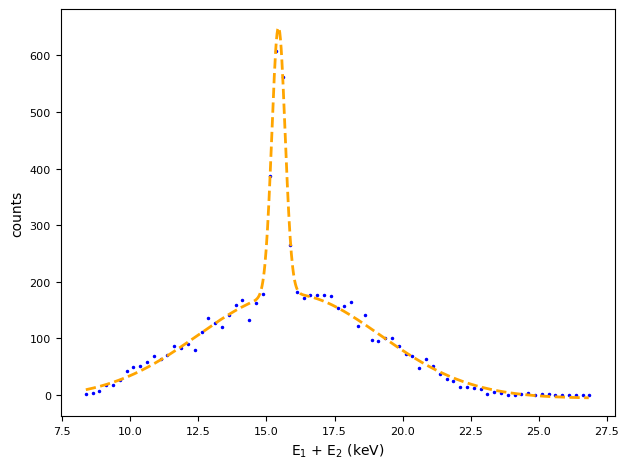

--> df dp
--> df dp dt
p0_guess: [220.0, 0, 11.56622490612736, 66.14375]
A: 180.98069590824142
N: 1207.7608587186169
x0: 0.8068692690369099
sigma: 16.43144980461666
const: 117.37920189804942
SN: 1.54184636615125
bin_size: 6.25


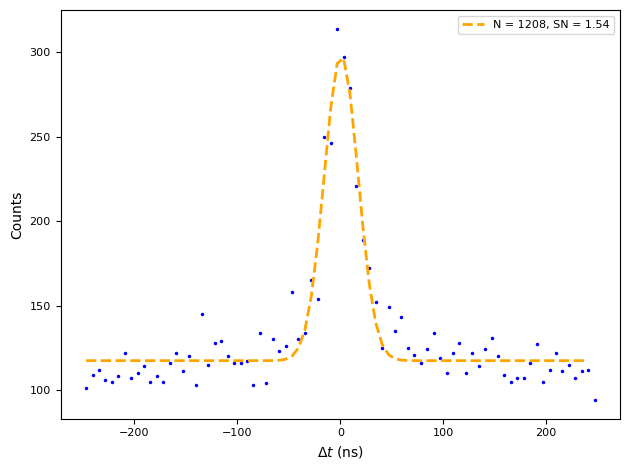

--> df dp dt Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 426.469462090875
N: 1762.3289247484984
x0_1: 15.370359242468771
sigma1: 0.2445578209092542
A2: 46.71144278967969
x0_2: 15.812580873773388
sigma2: 3.7628227585591985
const: -5.427277886932522
bin_size: 0.25


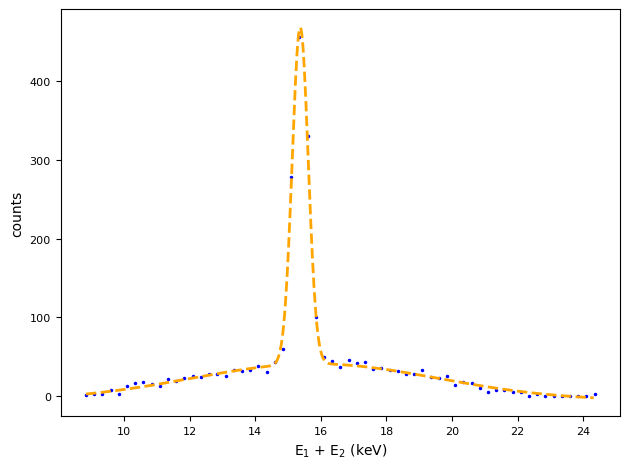

--> df dp Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 1170.0134000408525
N: 996.8742093992727
x0_1: 15.861200821204646
sigma1: 3.2992755622670544
A2: 441.76769541545053
x0_2: 15.400533796460017
sigma2: 0.22505904941573285
const: -32.03424473022678
bin_size: 0.25


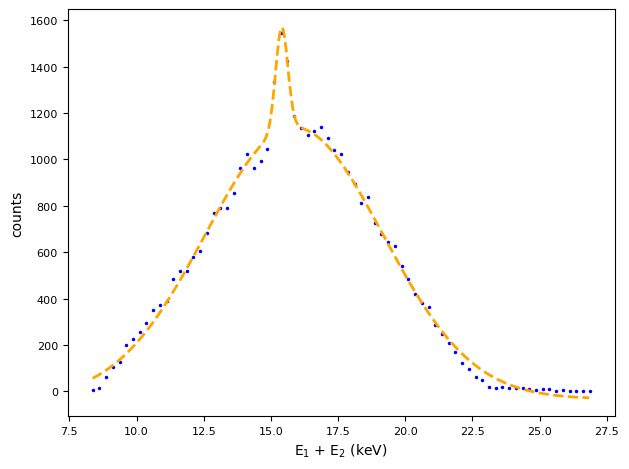

--> df dp Etot dt
p0_guess: [220.0, 0, 11.562374666958283, 65.44375]
A: 180.83106504678273
N: 1208.2934572090035
x0: 0.8713060985036405
sigma: 16.452298145294403
const: 115.97262763727201
SN: 1.5592564274077558
bin_size: 6.25


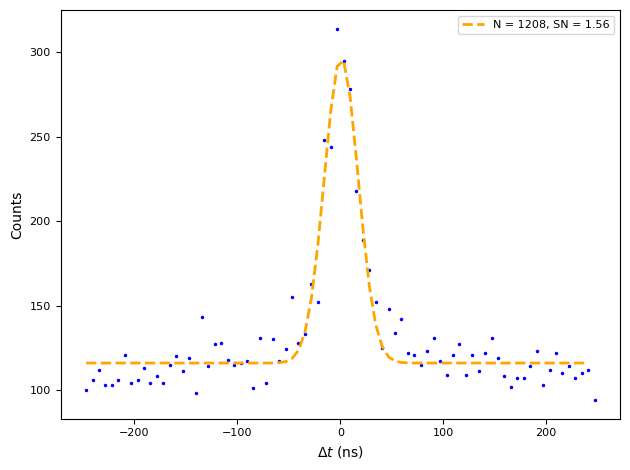


--> df Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 1279480.1958402784
N: 49304199.00302649
x0_1: 14.380794428461256
sigma1: 3.8850979660339626
A2: 1259559.225303752
x0_2: 14.363897231006952
sigma2: 3.9040501606603653
const: 178.92192696216225
bin_size: 0.25


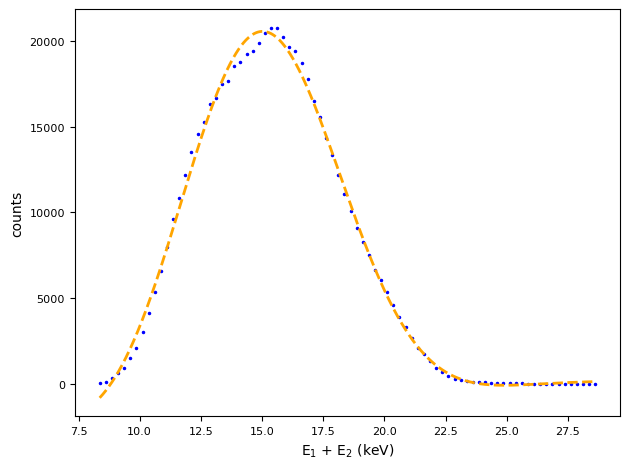


--> df Etot dt
p0_guess: [501.0, 0, 11.925529764470568, 982.08125]
A: 232.70124764980602
N: 6901.626587886352
x0: 1.992112282033228
sigma: 73.0264070829176
const: 1879.0232725572446
SN: 0.12384159954182619
bin_size: 6.25


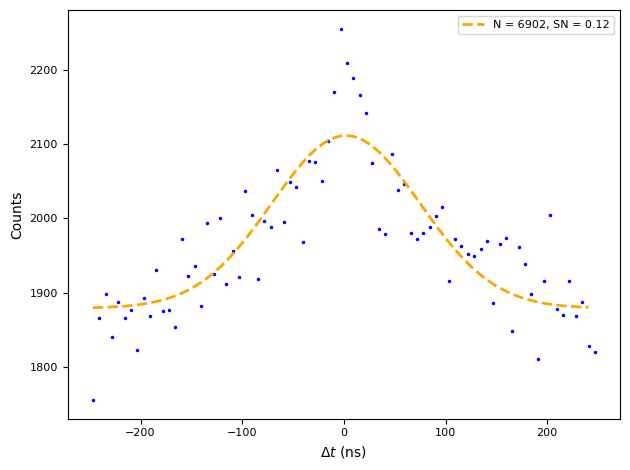


--> df Etot dt dp

--> df Etot dp

--> df Etot dp dt
p0_guess: [220.0, 0, 11.564832198608658, 65.6375]
A: 180.93874766335838
N: 1204.0831694078074
x0: 0.8966540850439908
sigma: 16.385213071236052
const: 116.41209837651697
SN: 1.5542950448169048
bin_size: 6.25


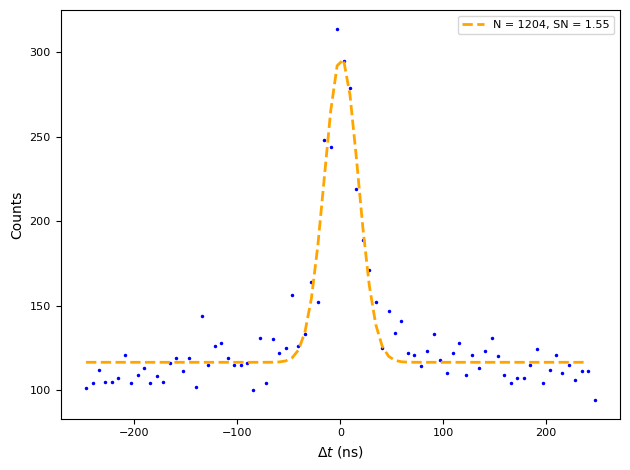

0.8068692690369099 16.43144980461666
15.370359242468771 0.2445578209092542
15.861200821204646 3.2992755622670544
0.8713060985036405 16.452298145294403
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 425.3101549296677
N: 1721.3325329587403
x0_1: 15.369722975027319
sigma1: 0.24420086588463458
A2: 45.69311036198666
x0_2: 15.859517037240309
sigma2: 3.7571984079629916
const: -5.262203879652483
bin_size: 0.25


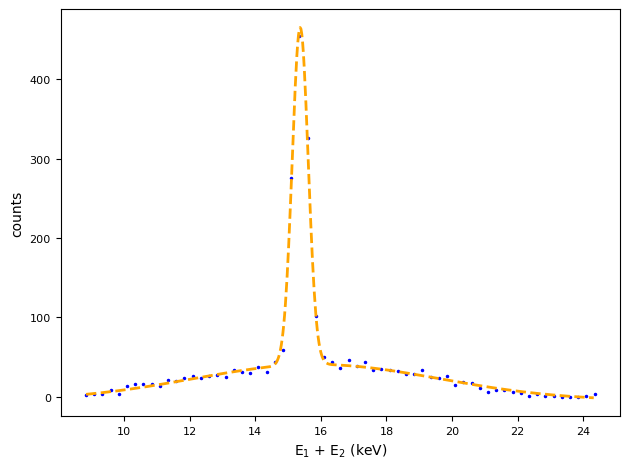

p0_guess: [173.0, 0, 10.090262163066408, 14.11875]
A: 168.20790887289854
N: 1070.9990442433211
x0: 0.23204314975959797
sigma: 15.677249097286586
const: 15.01735552523287
SN: 11.200900757145135
bin_size: 6.25


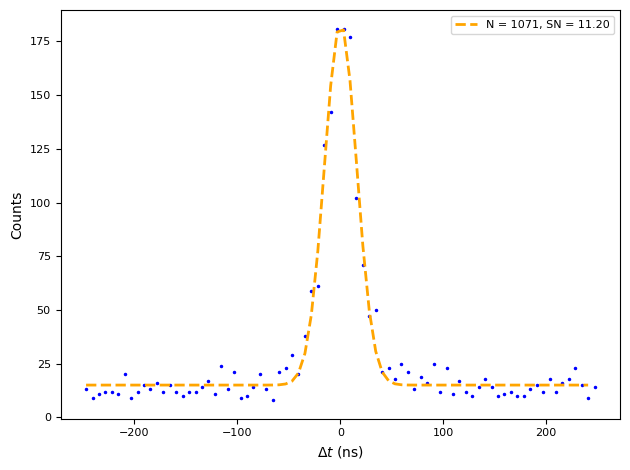

p0_guess: [246.0, 0, 11.75084596654831, 138.79375]
A: 188.7518742612836
N: 1255.4066468167998
x0: -0.023148599345406702
sigma: 16.376471676321707
const: 262.09107418167616
SN: 0.7201766593945305
bin_size: 6.25


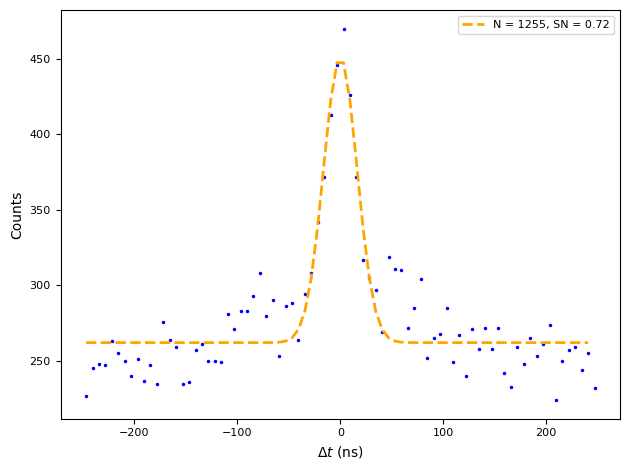

1171
1161
0.03995778082265407
Finding new pairs with updated scan_info.
Dropped rows after dropna: 20324864
Dropped rows after drop_duplicates on 'index_2': 7095
Pairs found after 431.0 seconds. Calculating pair info...
Basic pair info found after 14.1 seconds. Calculating detuning info...
Saving:
...saved after 0.6 seconds.
On loop 1
--> df dt
p0_guess: [508.0, 0, 11.924264389558378, 985.81875]
A: 236.65009653117096
N: 6954.494037544624
x0: 1.8699653706034887
sigma: 72.35791441552512
const: 1885.8402094313965
SN: 0.12548788351613513
bin_size: 6.25


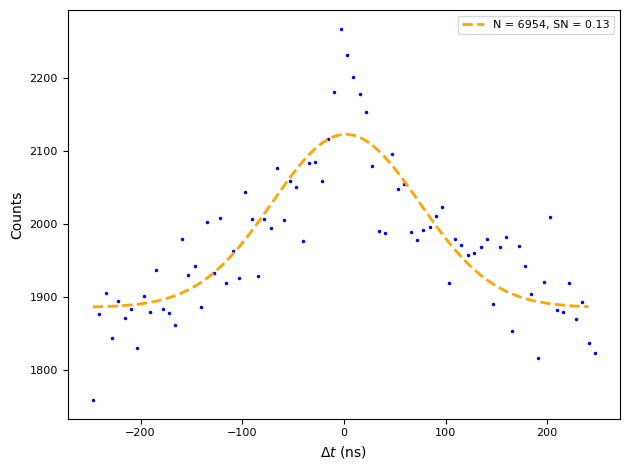


--> df dt Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 3303.909322829248
N: 6315.635032020177
x0_1: 15.090673206483542
sigma1: 2.6580188940216942
A2: 653.6178767936709
x0_2: 11.80133850329265
sigma2: 0.9637029261719019
const: -3.3162881850897064
bin_size: 0.25


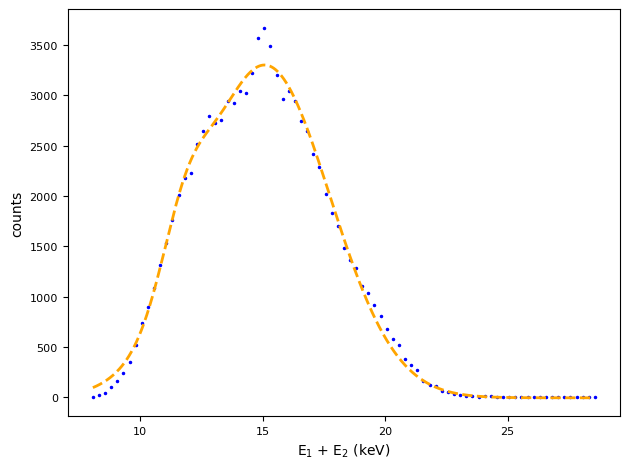


--> df dt Etot dp

--> df dt dp

--> df dt dp Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 472.6758695673834
N: 5993.530387207144
x0_1: 15.031992395558962
sigma1: 0.23831931733345493
A2: 185.5026665493785
x0_2: 15.370137281562888
sigma2: 3.222423597467838
const: -2.777312221468652
bin_size: 0.25


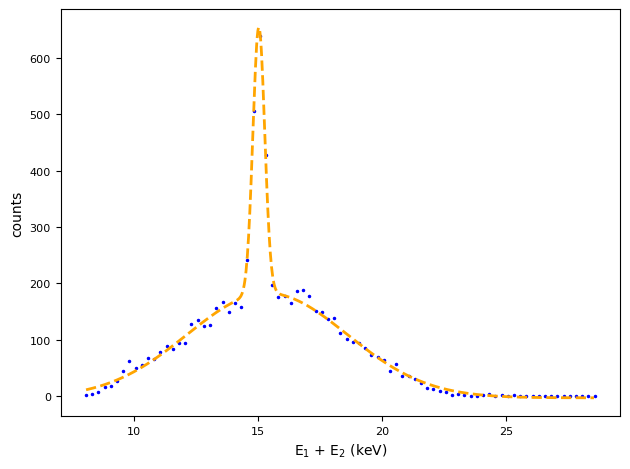

--> df dp
--> df dp dt
p0_guess: [217.0, 0, 11.588148545005547, 66.45625]
A: 176.6572336435881
N: 1217.6156796098605
x0: 0.9606546585636292
sigma: 16.97094375517585
const: 117.8825564446028
SN: 1.4985867203058634
bin_size: 6.25


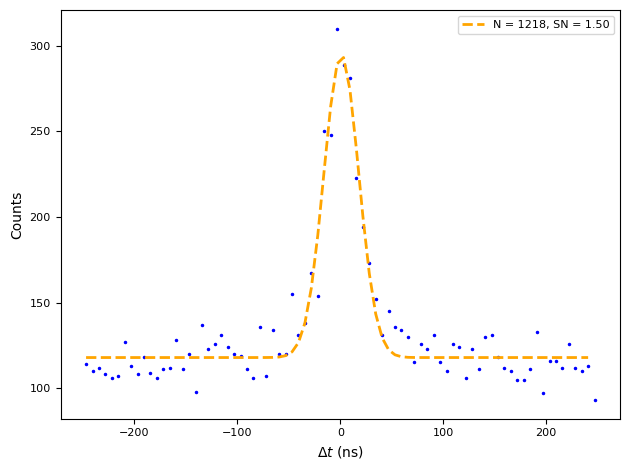

--> df dp dt Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 432.0983636397009
N: 1455.6323091875606
x0_1: 15.023964707976175
sigma1: 0.23816757571655348
A2: 44.46190014929716
x0_2: 15.394498708190044
sigma2: 3.265229729854835
const: -0.8001196493547093
bin_size: 0.25


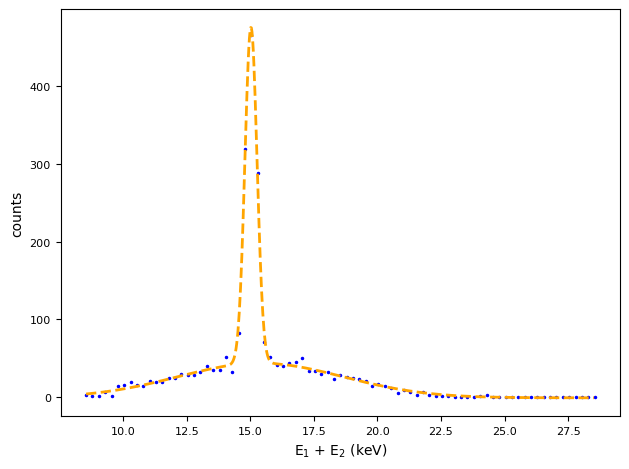

--> df dp Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 1171.726931640853
N: 970.6373779217643
x0_1: 15.444453995584935
sigma1: 3.1996711979658063
A2: 429.63278690078886
x0_2: 15.009376411214179
sigma2: 0.22532515021973576
const: -16.014050908736134
bin_size: 0.25


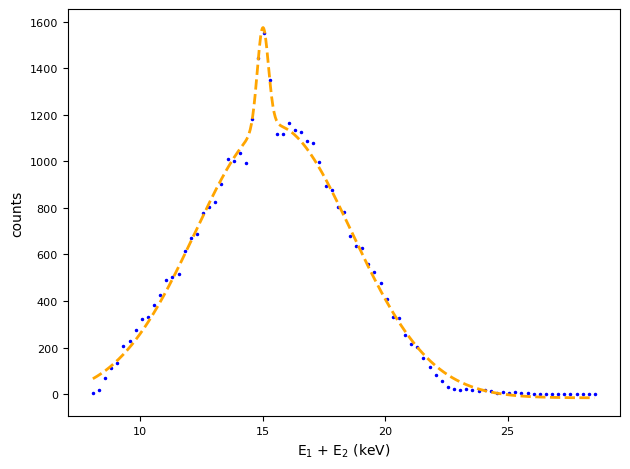

--> df dp Etot dt
p0_guess: [216.0, 0, 11.58402798085966, 65.54375]
A: 176.31925101410215
N: 1219.38257037016
x0: 1.077577886582151
sigma: 17.0281488603411
const: 116.03574638741229
SN: 1.5195252885728798
bin_size: 6.25


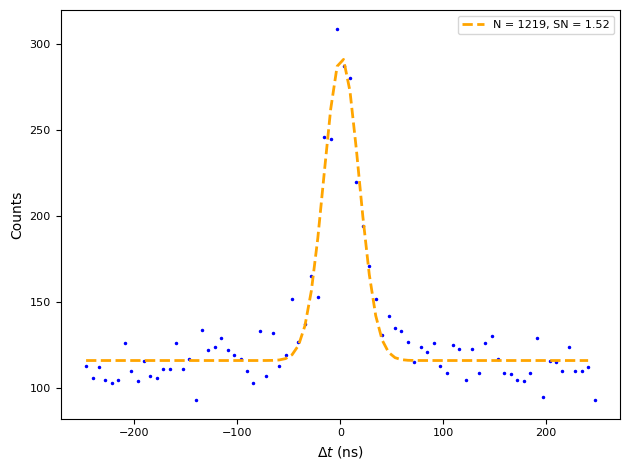


--> df Etot
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 1177302.811374068
N: 45064975.280532256
x0_1: 13.948131579614422
sigma1: 3.8631923402180792
A2: 1157313.4426688035
x0_2: 13.928573484324819
sigma2: 3.883633279846624
const: 151.7180244820487
bin_size: 0.25


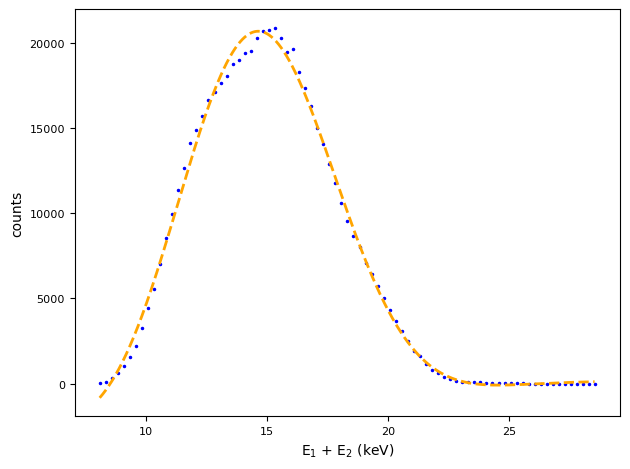


--> df Etot dt
p0_guess: [498.0, 0, 11.92563329168755, 981.38125]
A: 232.21019943656583
N: 6902.073222784958
x0: 1.774853020450552
sigma: 73.1855697770192
const: 1877.6191736126666
SN: 0.12367268224566415
bin_size: 6.25


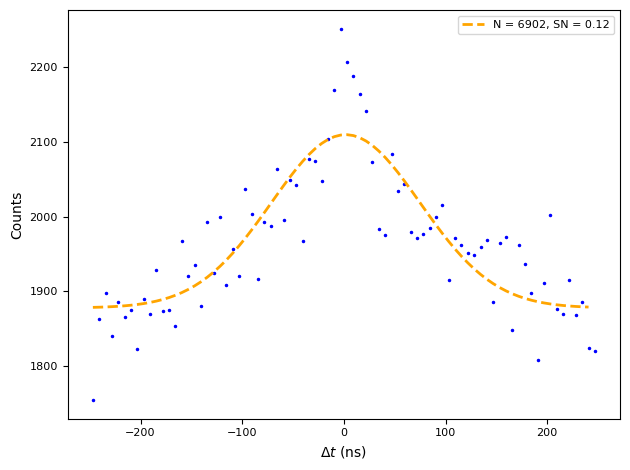


--> df Etot dt dp

--> df Etot dp

--> df Etot dp dt
p0_guess: [216.0, 0, 11.588666980003689, 65.85625]
A: 176.0249576940382
N: 1209.977170393824
x0: 1.1011830121757447
sigma: 16.92505602935047
const: 116.77684430129464
SN: 1.5073618297123883
bin_size: 6.25


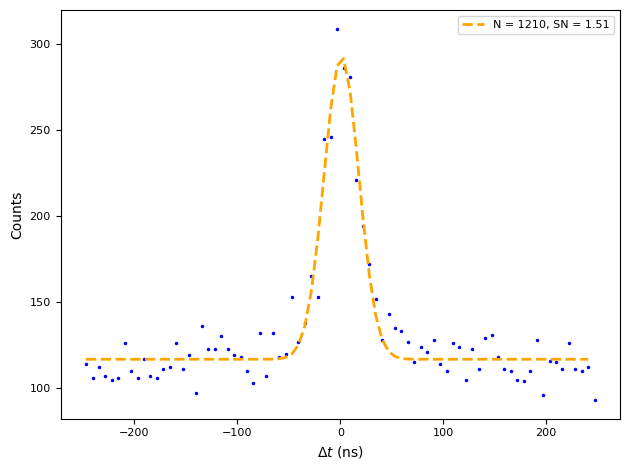

0.9606546585636292 16.97094375517585
15.023964707976175 0.23816757571655348
15.444453995584935 3.1996711979658063
1.077577886582151 17.0281488603411
p0_guess: [1200, 15, 0.5, 0, 200, 15, 3]
A1: 434.6957796766044
N: 1494.6427644900714
x0_1: 15.026050625090532
sigma1: 0.23867951009591828
A2: 45.31922750664978
x0_2: 15.372016895467164
sigma2: 3.289311323563921
const: -0.854563664915967
bin_size: 0.25


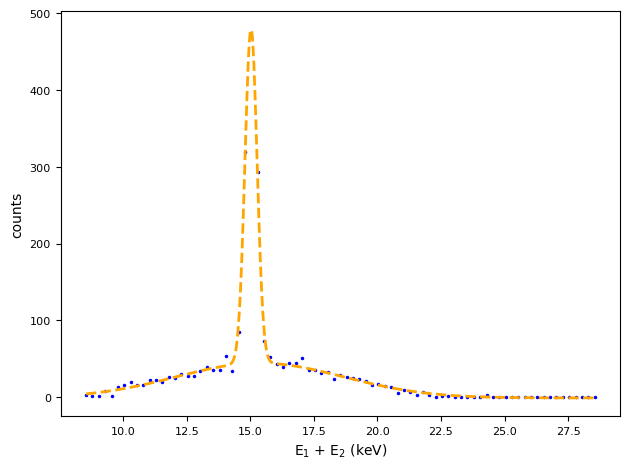

p0_guess: [175.0, 0, 10.128762347171874, 13.91875]
A: 168.43101252030715
N: 1070.0565568757243
x0: -0.1014864546712409
sigma: 15.642705194756672
const: 14.628989376155006
SN: 11.513509798212494
bin_size: 6.25


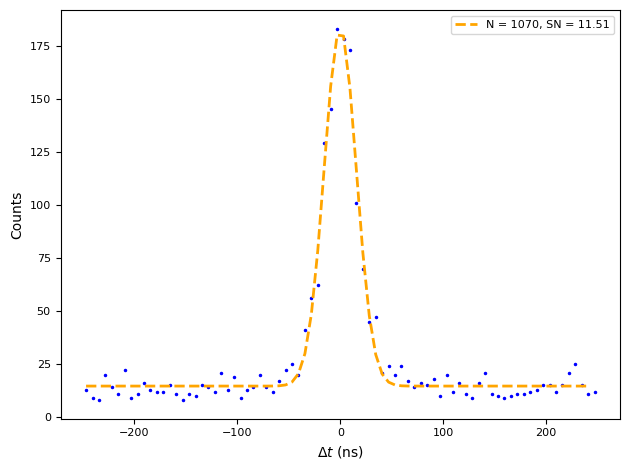

p0_guess: [239.0, 0, 11.73918390273057, 135.2125]
A: 188.65232732130144
N: 1276.0789458405025
x0: -0.2696122183635594
sigma: 16.654920479454354
const: 254.67340050347107
SN: 0.7407618029537019
bin_size: 6.25


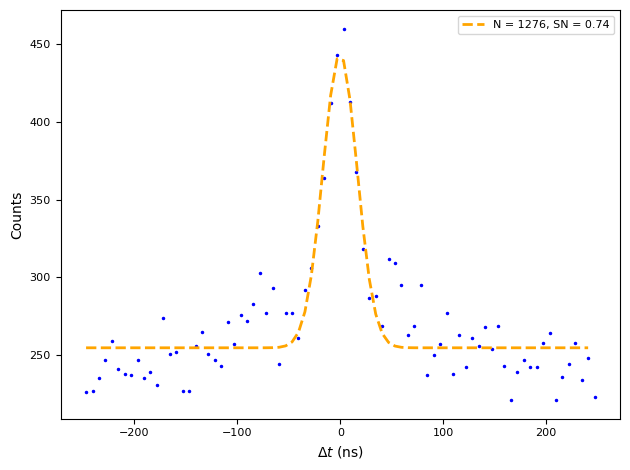

1182
1155
Initial detuning angle: 0.04198335352923799
Optimal detuning angle: 0.03995778082265407


In [11]:
### Perform in depth selections.

loop_count = 0

if all_selections: # do all combinations of the selections
    
    while loop_count < 2:
        
        print("On loop {}".format(loop_count))

        # delta_t selection
        print("--> df dt")
        df_dt, df_dt_stats = ts.dt_filter(df_pairs, dt_selection_range)

        print("\n--> df dt Etot")
        df_dt_Etot, df_dt_Etot_stats = ts.dE_filter(df_dt, Etot_selection_range)

        print("\n--> df dt Etot dp")
        df_dt_Etot_dp = ts.dp_filter(df_dt_Etot, dp_selection_range)

        print("\n--> df dt dp")
        df_dt_dp = ts.dp_filter(df_dt, dp_selection_range)

        print("\n--> df dt dp Etot")
        df_dt_dp_Etot, df_dt_dp_Etot_stats = ts.dE_filter(df_dt_dp, Etot_selection_range)

        # delta P selections
        print("--> df dp")
        df_dp = ts.dp_filter(df_pairs, dp_selection_range)

        print("--> df dp dt")
        df_dp_dt, df_dp_dt_stats = ts.dt_filter(df_dp, dt_selection_range)

        print("--> df dp dt Etot")
        df_dp_dt_Etot, df_dp_dt_Etot_stats = ts.dE_filter(df_dp_dt, Etot_selection_range)

        print("--> df dp Etot")
        df_dp_Etot, df_dp_Etot_stats = ts.dE_filter(df_dp, Etot_selection_range)

        print("--> df dp Etot dt")
        df_dp_Etot_dt, df_dp_Etot_dt_stats = ts.dt_filter(df_dp_Etot, dt_selection_range)

        # Etotal selections
        print("\n--> df Etot")
        df_Etot, df_Etot_stats = ts.dE_filter(df_pairs, Etot_selection_range)

        print("\n--> df Etot dt")
        df_Etot_dt, df_Etot_dt_stats = ts.dt_filter(df_Etot, dt_selection_range)

        print("\n--> df Etot dt dp")
        df_Etot_dt_dp = ts.dp_filter(df_Etot_dt, dp_selection_range)

        print("\n--> df Etot dp")
        df_Etot_dp = ts.dp_filter(df_Etot, dp_selection_range)

        print("\n--> df Etot dp dt")
        df_Etot_dp_dt, df_Etot_dp_dt_stats = ts.dt_filter(df_Etot_dp, dt_selection_range)

        if find_nominals:

            # df_dp_dt_Etot -> E0 and sigma
            t0_bad = df_dp_dt_stats['x0']
            tsigma_bad = df_dp_dt_stats['sigma']
            print(t0_bad, tsigma_bad)

            E0 = df_dp_dt_Etot_stats['x0_1']
            Esigma = df_dp_dt_Etot_stats['sigma1']
            print(E0, Esigma)

            # dp_dp_Etot_dt -> t0 and sigma
            E0_bad = df_dp_Etot_stats['x0_1']
            Esigma_bad = df_dp_Etot_stats['sigma1']
            print(E0_bad, Esigma_bad)

            t0 = df_dp_Etot_dt_stats['x0']
            tsigma = df_dp_Etot_dt_stats['sigma']
            print(t0, tsigma)

        # first iteration:
        df_dp_dt2 = df_dp[(df_dp['delta_t'] >= t0 - tsigma*dt_selection_range) & (df_dp['delta_t'] <= t0 + tsigma*dt_selection_range)]
        df_dp_dt2_Etot, df_dp_dt2_Etot_stats = ts.dE_filter(df_dp_dt2, Etot_selection_range)

        df_dp_Etot2 = df_dp[(df_dp['E_tot'] >= E0 - Esigma*Etot_selection_range) & (df_dp['E_tot'] <= E0 + Esigma*Etot_selection_range)]
        df_dp_Etot2_dt, df_dp_Etot2_dt_stats = ts.dt_filter(df_dp_Etot2, dt_selection_range)

        if save_selections and loop_count == 1:
            df_dp_Etot2_dt.to_hdf(save_folder + "data/selections/selections_{}.h5".format(scan_info['sid']), key='df', mode='w')
            with h5py.File(save_folder + "data/selections/selections_{}.h5".format(scan_info['sid']), 'a') as h5f:
                h5f.create_dataset('scan_info', data=np.array(json.dumps(scan_info), dtype='S'))

        df_Etot2 = df_pairs[(df_pairs['E_tot'] >= E0 - Esigma*Etot_selection_range) & (df_pairs['E_tot'] <= E0 + Esigma*Etot_selection_range)]
        df_Etot2_dt, df_Etot2_dt_stats = ts.dt_filter(df_Etot2, dt_selection_range)

        print(len(df_dp_dt2_Etot))
        print(len(df_dp_Etot2_dt))
        
        if loop_count == 0:
    
            optimal_del_theta = ts.get_optimal_del_theta(df_dp_Etot2_dt, scan_info)[0]
            print(optimal_del_theta)
            old_del_theta = scan_info['del_theta']
            scan_info['del_theta'] = optimal_del_theta
            
            t8 = time.time()
            print("Finding new pairs with updated scan_info.")
            df_pairs = ts.get_pairs_pandas(df, chans1 = [1,2], chans2 = [3,4])
            print(f"Pairs found after {(t8-t7):.1f} seconds. Calculating pair info...")
            df_pairs = ts.calculate_pair_info_pandas(df_pairs, x_cen = scan_info['x_cen'], y_cen = scan_info['y_cen'], Epump = scan_info['Epump'], dd = scan_info['dd'], del_theta = scan_info['del_theta'], theta = scan_info['theta'])
            t9 = time.time()
            print(f"Basic pair info found after {(t9-t8):.1f} seconds. Calculating detuning info...")
            df_pairs = ts.calculate_detuning_info(df_pairs, x_cen = scan_info['x_cen'], y_cen = scan_info['y_cen'], Epump = scan_info['Epump'], dd = scan_info['dd'], del_theta = scan_info['del_theta'], theta = scan_info['theta'])

            if save_pairs:
                df_pairs.drop(columns=['pair_id'], inplace=True)
                print("Saving:")
                t10 = time.time()
                df_pairs.to_hdf(save_folder + "data/pairs/pairs_{}.h5".format(scan_info['sid']), format='table', key='df', mode='w')
                with h5py.File(save_folder + "data/pairs/pairs_{}.h5".format(scan_info['sid']), 'a') as h5f:
                    h5f.create_dataset('scan_info', data=np.array(json.dumps(scan_info), dtype='S'))
                print(f"...saved after {(time.time()-t10):.1f} seconds.")
                
        loop_count = loop_count + 1
        
print("Initial detuning angle: {}".format(old_del_theta))
print("Optimal detuning angle: {}".format(optimal_del_theta))

# plots below 
## these are just examples/stuff we made for the figure
## many other sorts of plots could be generated from the dataframes!
## for example, distance of pairs histogram could be generated using df['dist']
## if there are other things we want to calculate, we can add the functions to tpxspdc.calculate_pair_info()!
### -------------------

## raw data

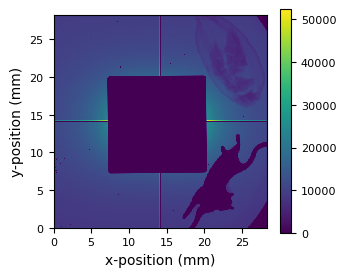

In [12]:
fname = 'efig1a_'+plot_folder
binsize = 1

hist, xedges, yedges = ts.histogram2d_fast(_df['xc'], _df['yc'], bins=int(npixels/binsize), range=[(0, npixels), (0, npixels)])
xedges_mm = xedges * pixel_to_mm
yedges_mm = yedges * pixel_to_mm

plt.figure(figsize=figsize_sing)

plt.pcolormesh(xedges_mm, yedges_mm, hist)

plt.xlabel('x-position (mm)', fontsize=labelsize)
plt.ylabel('y-position (mm)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.gca().set_aspect('equal')

cbar = plt.colorbar(shrink=0.72)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

## delta_t selections

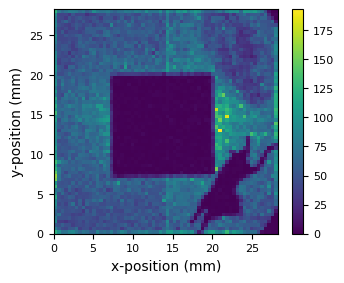

In [13]:
fname = 'efig1b_'+plot_folder
binsize = 8

hist, xedges, yedges = ts.histogram2d_fast(np.concatenate((df_dt['xc_1'], df_dt['xc_2'])), np.concatenate((df_dt['yc_1'], df_dt['yc_2'])), bins=int(npixels/binsize), range=[(0, npixels), (0, npixels)])
xedges_mm = xedges * pixel_to_mm
yedges_mm = yedges * pixel_to_mm

plt.figure(figsize=figsize_sing)

plt.pcolormesh(xedges_mm, yedges_mm, hist)

plt.xlabel('x-position (mm)', fontsize=labelsize)
plt.ylabel('y-position (mm)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.gca().set_aspect('equal')

cbar = plt.colorbar(shrink=0.72)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

## delta_t and E_tot ring

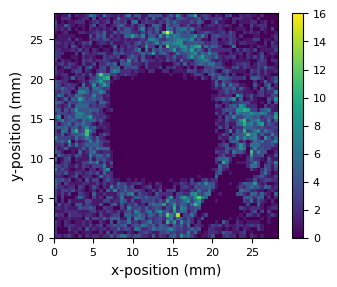

In [14]:
fname = 'efig1c_'+plot_folder
binsize = 8

# Maybe this could go into tpxsdc. Should use fast_histogram
hist, xedges, yedges = ts.histogram2d_fast(np.concatenate((df_Etot2_dt['xc_1'], df_Etot2_dt['xc_2'])), np.concatenate((df_Etot2_dt['yc_1'], df_Etot2_dt['yc_2'])), bins=int(npixels/binsize), range=[(0, npixels), (0, npixels)])
xedges_mm = xedges * pixel_to_mm
yedges_mm = yedges * pixel_to_mm

plt.figure(figsize=figsize_sing)

plt.pcolormesh(xedges_mm, yedges_mm, hist)

plt.xlabel('x-position (mm)', fontsize=labelsize)
plt.ylabel('y-position (mm)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.gca().set_aspect('equal')

cbar = plt.colorbar(shrink = 0.72)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

## delta_t and Etot and dp ring (final ring)

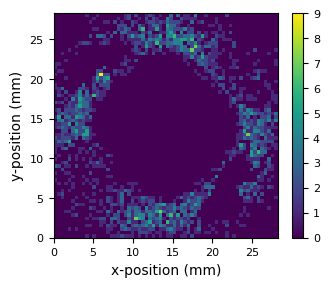

In [15]:
fname = 'fig1a_'+plot_folder
binsize = 8

# Maybe this could go into tpxsdc. Should use fast_histogram
hist, xedges, yedges = ts.histogram2d_fast(np.concatenate((df_dp_Etot2_dt['xc_1'], df_dp_Etot2_dt['xc_2'])), np.concatenate((df_dp_Etot2_dt['yc_1'], df_dp_Etot2_dt['yc_2'])), bins=int(npixels/binsize), range=[(0, npixels), (0, npixels)])
xedges_mm = xedges * pixel_to_mm
yedges_mm = yedges * pixel_to_mm

plt.figure(figsize=figsize_sing)

plt.pcolormesh(xedges_mm, yedges_mm, hist)

plt.xlabel('x-position (mm)', fontsize=labelsize)
plt.ylabel('y-position (mm)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.gca().set_aspect('equal')

cbar = plt.colorbar(shrink = 0.72)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

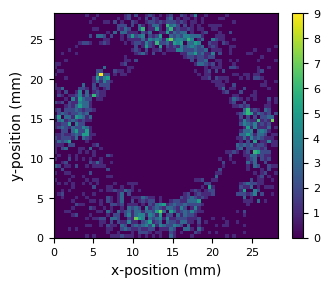

In [16]:
fname = 'fig1b_'+plot_folder

hist, xedges, yedges = ts.histogram2d_fast(np.concatenate((df_dp_Etot2_dt['xc_1_p'], df_dp_Etot2_dt['xc_2'])), np.concatenate((df_dp_Etot2_dt['yc_1_p'], df_dp_Etot2_dt['yc_2'])), bins=int(npixels/binsize), range=[(0, npixels), (0, npixels)])
xedges_mm = xedges * pixel_to_mm
yedges_mm = yedges * pixel_to_mm

plt.figure(figsize=figsize_sing)

plt.pcolormesh(xedges_mm, yedges_mm, hist)

plt.xlabel('x-position (mm)', fontsize=labelsize)
plt.ylabel('y-position (mm)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.gca().set_aspect('equal')

cbar = plt.colorbar(shrink = 0.72)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()

## delta t histograms

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_116649/2283253485.py:10: SyntaxWarning: invalid escape sequence '\s'
  """
/tmp/ipykernel_116649/2283253485.py:16: SyntaxWarning: invalid escape sequence '\s'
  """
/tmp/ipykernel_116649/2283253485.py:24: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta t$ (ns)", fontsize=labelsize)


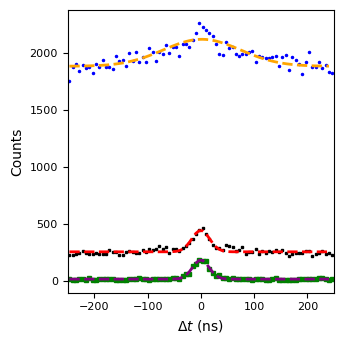

Time: N = 6954, SN = 0.13, sigma = 72.36
Time & Energy: N = 1276, SN = 0.74, sigma = 16.65
Time, Energy, Momentum: N = 1070, SN = 11.5, sigma = 15.64


In [17]:
fname = 'test2_'+plot_folder

set_color = 'red'; width = 3.0; alpha = 1.0; fmt = "-"

from matplotlib.cm import get_cmap
plt.figure(figsize=figsize_sing)

plt.plot(df_dt_stats['h_centers'], df_dt_stats['h_counts'], '.', color='blue', markersize=3.0)
plt.plot(df_dt_stats['model_x_vals'], df_dt_stats['model_y_vals'], '--', color='orange', linewidth=2.0, label='ToT selections only:\nN = {:.0f}, SN = {:.2f}'.format(df_dt_stats['N'], df_dt_stats['SN']))
"""
            label="ToT selections only: \n $N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $t_0$ = {:.2f} \u00B1 {:.2f} ns \n $\sigma$ = {:.2f} \u00B1 {:.2f} ns \n SNR = {:.2f} \u00B1 {:.2f}".format(
                abs(dt_N), abs(dt_N_err), dt_t0, dt_t0_err, abs(dt_sigma), dt_sigma_err, dt_SN, dt_SN_err))
"""
plt.plot(df_Etot2_dt_stats['h_centers'], df_Etot2_dt_stats['h_counts'], 's', color='black', markersize=2.0)
plt.plot(df_Etot2_dt_stats['model_x_vals'], df_Etot2_dt_stats['model_y_vals'], '--', color='red', linewidth=2.0, label='ToT & $E_{{total}}$ selections:\nN = {:.0f}, SN = {:.2f}'.format(df_Etot2_dt_stats['N'], df_Etot2_dt_stats['SN']))
"""
            label="ToT & $E_{{total}}$ = 15 keV selections: \n $N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $t_0$ = {:.2f} \u00B1 {:.2f} ns \n $\sigma$ = {:.2f} \u00B1 {:.2f} ns \n SNR = {:.2f} \u00B1 {:.2f}".format(
                abs(dtE_N), abs(dtE_N_err), abs(dtE_t0), dtE_t0_err, abs(dtE_sigma), dtE_sigma_err, dtE_SN, dtE_SN_err))
"""
                
plt.plot(df_dp_Etot2_dt_stats['h_centers'], df_dp_Etot2_dt_stats['h_counts'], 's', color='green', markersize=3.0)
plt.plot(df_dp_Etot2_dt_stats['model_x_vals'], df_dp_Etot2_dt_stats['model_y_vals'], '--', color='purple', linewidth=2.0, label='ToT & $E_{{total}}$ & dp < {} selections:\nN = {:.0f}, SN = {:.2f}'.format(dp_selection_range,df_dp_Etot2_dt_stats['N'],df_dp_Etot2_dt_stats['SN']))

plt.xlabel("$\Delta t$ (ns)", fontsize=labelsize)
plt.ylabel("Counts", fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.xlim([-250, 250])

#plt.legend(fontsize=8)

plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

print("Time: N = {:.0f}, SN = {:.2f}, sigma = {:.2f}".format(df_dt_stats['N'], df_dt_stats['SN'], df_dt_stats['sigma']))
print("Time & Energy: N = {:.0f}, SN = {:.2f}, sigma = {:.2f}".format(df_Etot2_dt_stats['N'], df_Etot2_dt_stats['SN'], df_Etot2_dt_stats['sigma']))
print("Time, Energy, Momentum: N = {:.0f}, SN = {:.1f}, sigma = {:.2f}".format(df_dp_Etot2_dt_stats['N'], df_dp_Etot2_dt_stats['SN'], df_dp_Etot2_dt_stats['sigma']))

## dr positions / closest position on line segment

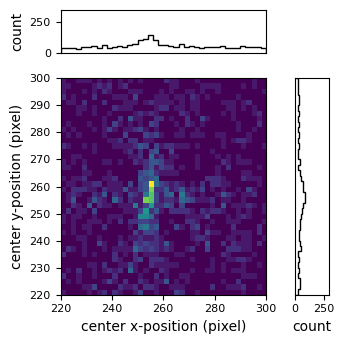

In [18]:
fname = 'fig3a_'+plot_folder

# Should use fast_histogram

cen_min = 220
cen_max = 300
binsize = 2

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = figsize_sing, gridspec_kw = {"width_ratios": [3,0.5], "height_ratios": [1,5]})

ax0 = ax[1,0]
ax1 = ax[1,1]
ax2 = ax[0,0]
ax[0,1].axis("off")

hist, xedge, yedge = ts.histogram2d_fast(df_Etot2_dt['x_cen'], df_Etot2_dt['y_cen'], bins = int((cen_max-cen_min)/binsize), range=[[cen_min, cen_max], [cen_min, cen_max]])
h = ax0.imshow(hist, interpolation='none', origin='lower',extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]],aspect='auto')

plt.subplots_adjust(wspace = 0.2)
plt.subplots_adjust(hspace = 0.15)
ax1.hist(df_Etot2_dt['y_cen'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step', orientation = "horizontal")
ax2.hist(df_Etot2_dt['x_cen'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step')
ax0.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)#ax1.yaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_ylim([cen_min, cen_max])
ax1.set_xlim([0, 300])
ax1.set_xlabel("count")
ax2.set_xlim([cen_min, cen_max])
ax2.set_ylim([0, 350])
ax2.set_ylabel("count")
ax2.xaxis.set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax0.set_xlabel("center x-position (pixel)", fontsize = labelsize)
ax0.set_ylabel("center y-position (pixel)", fontsize = labelsize)
plt.tight_layout() 
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

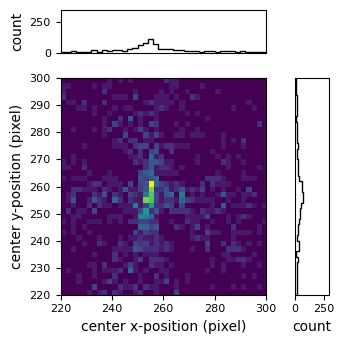

In [19]:
fname = 'fig3a_'+plot_folder

# Should use fast_histogram

cen_min = 220
cen_max = 300
binsize = 2

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = figsize_sing, gridspec_kw = {"width_ratios": [3,0.5], "height_ratios": [1,5]})

ax0 = ax[1,0]
ax1 = ax[1,1]
ax2 = ax[0,0]
ax[0,1].axis("off")

hist, xedge, yedge = ts.histogram2d_fast(df_dp_Etot2_dt['x_cen'], df_dp_Etot2_dt['y_cen'], bins = int((cen_max-cen_min)/binsize), range=[[cen_min, cen_max], [cen_min, cen_max]])
h = ax0.imshow(hist, interpolation='none', origin='lower',extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]],aspect='auto')

plt.subplots_adjust(wspace = 0.2)
plt.subplots_adjust(hspace = 0.15)
ax1.hist(df_dp_Etot2_dt['y_cen'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step', orientation = "horizontal")
ax2.hist(df_dp_Etot2_dt['x_cen'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step')
ax0.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)#ax1.yaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_ylim([cen_min, cen_max])
ax1.set_xlim([0, 300])
ax1.set_xlabel("count")
ax2.set_xlim([cen_min, cen_max])
ax2.set_ylim([0, 350])
ax2.set_ylabel("count")
ax2.xaxis.set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax0.set_xlabel("center x-position (pixel)", fontsize = labelsize)
ax0.set_ylabel("center y-position (pixel)", fontsize = labelsize)
plt.tight_layout() 
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

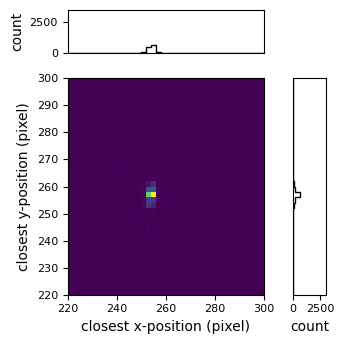

In [20]:
fname = 'fig3b_'+plot_folder

cen_min = 220
cen_max = 300
binsize = 2

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = figsize_sing, gridspec_kw = {"width_ratios": [3,0.5], "height_ratios": [1,5]})

ax0 = ax[1,0]
ax1 = ax[1,1]
ax2 = ax[0,0]
ax[0,1].axis("off")

hist, xedge, yedge = ts.histogram2d_fast(df_Etot2_dt['xp'], df_Etot2_dt['yp'], bins = int((cen_max-cen_min)/binsize), range=[[cen_min, cen_max], [cen_min, cen_max]])
h = ax0.imshow(hist, interpolation='none', origin='lower',extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]],aspect='auto')

# h = ax0.hist2d(df_dt_Etot['xp'], df_dt_Etot['yp'], bins = ((np.arange(cen_min, cen_max + binsize, binsize)), (np.arange(cen_min, cen_max + binsize, binsize))))
plt.subplots_adjust(wspace = 0.2)
plt.subplots_adjust(hspace = 0.15)
ax1.hist(df_Etot2_dt['yp'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step', orientation = "horizontal")
ax2.hist(df_Etot2_dt['xp'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step')
ax0.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)#ax1.yaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_ylim([cen_min, cen_max])
ax1.set_xlim([0, 3000])
ax1.set_xlabel("count")
ax2.set_xlim([cen_min, cen_max])
ax2.set_ylim([0, 3500])
ax2.set_ylabel("count")
ax2.xaxis.set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax0.set_xlabel("closest x-position (pixel)", fontsize = labelsize)
ax0.set_ylabel("closest y-position (pixel)", fontsize = labelsize)
plt.tight_layout() 
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

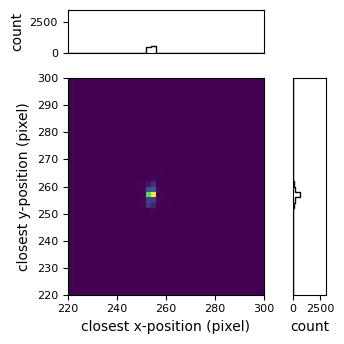

In [21]:
fname = 'fig3b_'+plot_folder

cen_min = 220
cen_max = 300
binsize = 2

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = figsize_sing, gridspec_kw = {"width_ratios": [3,0.5], "height_ratios": [1,5]})

ax0 = ax[1,0]
ax1 = ax[1,1]
ax2 = ax[0,0]
ax[0,1].axis("off")

hist, xedge, yedge = ts.histogram2d_fast(df_dp_dt2_Etot['xp'], df_dp_dt2_Etot['yp'], bins = int((cen_max-cen_min)/binsize), range=[[cen_min, cen_max], [cen_min, cen_max]])
h = ax0.imshow(hist, interpolation='none', origin='lower',extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]],aspect='auto')

# h = ax0.hist2d(df_dt_Etot['xp'], df_dt_Etot['yp'], bins = ((np.arange(cen_min, cen_max + binsize, binsize)), (np.arange(cen_min, cen_max + binsize, binsize))))
plt.subplots_adjust(wspace = 0.2)
plt.subplots_adjust(hspace = 0.15)
ax1.hist(df_dp_dt2_Etot['yp'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step', orientation = "horizontal")
ax2.hist(df_dp_dt2_Etot['xp'], bins = np.arange(cen_min, cen_max + binsize, binsize), color='black', range = (cen_min, cen_max), histtype = 'step')
ax0.tick_params(axis='both', which='major', labelsize=ticksize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)#ax1.yaxis.set_visible(False)
ax1.yaxis.set_visible(False)
ax1.set_ylim([cen_min, cen_max])
ax1.set_xlim([0, 3000])
ax1.set_xlabel("count")
ax2.set_xlim([cen_min, cen_max])
ax2.set_ylim([0, 3500])
ax2.set_ylabel("count")
ax2.xaxis.set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax0.set_xlabel("closest x-position (pixel)", fontsize = labelsize)
ax0.set_ylabel("closest y-position (pixel)", fontsize = labelsize)
plt.tight_layout() 
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

## energy and angle anti-correlations

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_116649/3741624005.py:20: SyntaxWarning: invalid escape sequence '\s'
  label="$N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $E_0$ = {:.1f} keV \n  $\sigma$ = {:.2f}  keV".format(


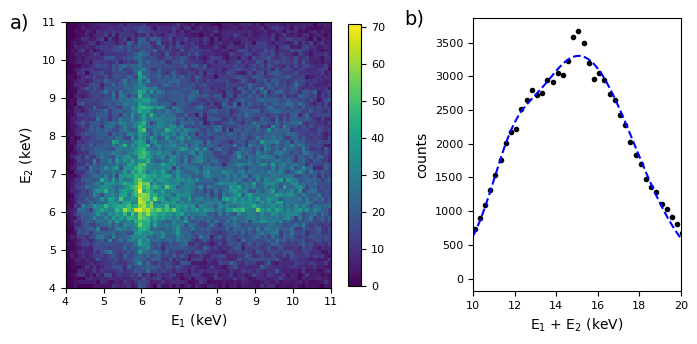

In [22]:
fname = 'fig4_'+plot_folder

fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.6, 1]})

hist, xedge, yedge = ts.histogram2d_fast(df_dt['E_1'], df_dt['E_2'], range=((4, 11), (4, 11)), bins=70)
im = axs[0].imshow(hist, interpolation='none', origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto')

# im = axs[0].hist2d(df_dt['E_1'], df_dt['E_2'], range=((4, 11), (4, 11)), bins=70)
axs[0].set_xlabel('E$_{1}$ (keV)', fontsize=labelsize)
axs[0].set_ylabel('E$_{2}$ (keV)', fontsize=labelsize)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].set_aspect('equal')  # Set aspect ratio to be equal for a square plot
cbar = fig.colorbar(im, ax=axs[0], shrink=.96)
cbar.ax.tick_params(labelsize=ticksize)
axs[0].annotate('a)', xy=(0, 1), xycoords='axes fraction', xytext=(-40, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)

axs[1].plot(df_dt_Etot_stats['h_centers'], df_dt_Etot_stats['h_counts'], '.', color='black')
axs[1].plot(df_dt_Etot_stats['model_x_vals'], df_dt_Etot_stats['model_y_vals'], '--', color='blue',
            label="$N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $E_0$ = {:.1f} keV \n  $\sigma$ = {:.2f}  keV".format(
                abs(df_dt_Etot_stats['N']), abs(df_dt_Etot_stats['N_err']), df_dt_Etot_stats['x0_2'], abs(df_dt_Etot_stats['sigma2'])))
axs[1].set_xlabel("E$_1$ + E$_2$ (keV)", fontsize=labelsize)
axs[1].set_ylabel("counts", fontsize=labelsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)
axs[1].set_xlim((10, 20))
axs[1].annotate('b)', xy=(0, 1), xycoords='axes fraction', xytext=(-50, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)

plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_116649/1391091537.py:20: SyntaxWarning: invalid escape sequence '\s'
  label="$N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $E_0$ = {:.1f} keV \n  $\sigma$ = {:.2f}  keV".format(


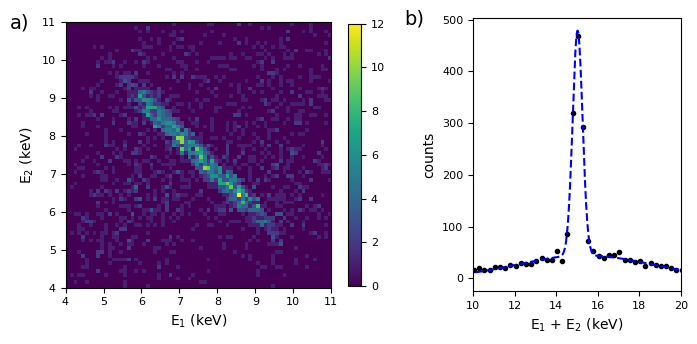

In [23]:
fname = 'fig4_'+plot_folder

fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.6, 1]})

hist, xedge, yedge = ts.histogram2d_fast(df_dp_dt2['E_1'], df_dp_dt2['E_2'], range=((4, 11), (4, 11)), bins=70)
im = axs[0].imshow(hist, interpolation='none', origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto')

# im = axs[0].hist2d(df_dt['E_1'], df_dt['E_2'], range=((4, 11), (4, 11)), bins=70)
axs[0].set_xlabel('E$_{1}$ (keV)', fontsize=labelsize)
axs[0].set_ylabel('E$_{2}$ (keV)', fontsize=labelsize)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].set_aspect('equal')  # Set aspect ratio to be equal for a square plot
cbar = fig.colorbar(im, ax=axs[0], shrink=.96)
cbar.ax.tick_params(labelsize=ticksize)
axs[0].annotate('a)', xy=(0, 1), xycoords='axes fraction', xytext=(-40, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)

axs[1].plot(df_dp_dt2_Etot_stats['h_centers'], df_dp_dt2_Etot_stats['h_counts'], '.', color='black')
axs[1].plot(df_dp_dt2_Etot_stats['model_x_vals'], df_dp_dt2_Etot_stats['model_y_vals'], '--', color='blue',
            label="$N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $E_0$ = {:.1f} keV \n  $\sigma$ = {:.2f}  keV".format(
                abs(df_dt_Etot_stats['N']), abs(df_dt_Etot_stats['N_err']), df_dt_Etot_stats['x0_2'], abs(df_dt_Etot_stats['sigma2'])))
axs[1].set_xlabel("E$_1$ + E$_2$ (keV)", fontsize=labelsize)
axs[1].set_ylabel("counts", fontsize=labelsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)
axs[1].set_xlim((10, 20))
axs[1].annotate('b)', xy=(0, 1), xycoords='axes fraction', xytext=(-50, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)

plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

/nsls2/users/jgoodrich/gh/chx_timepix/tpxspdc.py:698: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss, h_centers, h_counts, p0 = p0_guess, maxfev = 5000)
/nsls2/users/jgoodrich/gh/chx_timepix/tpxspdc.py:721: RuntimeWarning: invalid value encountered in scalar multiply
  N_err = N*np.sqrt((A_err/A)**2 + (sigma_err/sigma)**2)
/nsls2/users/jgoodrich/gh/chx_timepix/tpxspdc.py:722: RuntimeWarning: invalid value encountered in scalar divide
  SN = A/const


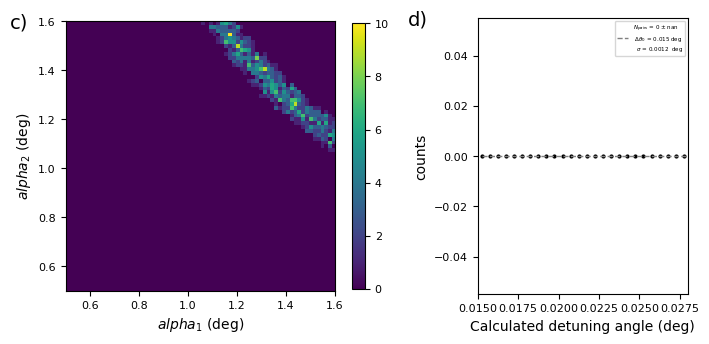

In [24]:
fname = 'fig4b_'+plot_folder

fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.6, 1]})

hist, xedge, yedge = ts.histogram2d_fast(np.degrees(df_dp_Etot2_dt['alpha_1']), np.degrees(df_dp_Etot2_dt['alpha_2']), range=((0.5, 1.6), (0.5, 1.6)), bins=70)

delta_theta_stats = ts.gauss_fit_series(np.degrees(df_dp_Etot2_dt['del_theta']), bin_size =0.0005, model_bin_size = 0.0001, srange=[0.015, 0.03])

im = axs[0].imshow(hist, interpolation='none', origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]], aspect='auto')

# im = axs[0].hist2d(df_dt['E_1'], df_dt['E_2'], range=((4, 11), (4, 11)), bins=70)
axs[0].set_xlabel("$alpha_{1}$ (deg)", fontsize=labelsize)
axs[0].set_ylabel("$alpha_{2}$ (deg)", fontsize=labelsize)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)
axs[0].set_aspect('equal')  # Set aspect ratio to be equal for a square plot
cbar = fig.colorbar(im, ax=axs[0], shrink=.96)
cbar.ax.tick_params(labelsize=ticksize)
axs[0].annotate('c)', xy=(0, 1), xycoords='axes fraction', xytext=(-40, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)
axs[0].set_xlim([0.5, 1.6])
axs[0].set_ylim([0.5, 1.6])



axs[1].plot(delta_theta_stats['h_centers'], delta_theta_stats['h_counts'], 'o', color='black', markersize = 2.0)
axs[1].plot(delta_theta_stats['model_x_vals'], delta_theta_stats['model_y_vals'], '--', color='grey', linewidth=1.0,
            label="$N_{{pairs}}$ = {:.0f} \u00B1 {:.0f} \n $\\Delta \\theta_0$ = {:.3f} deg \n  $\\sigma$ = {:.4f}  deg".format(
                abs(delta_theta_stats['N']), abs(delta_theta_stats['N_err']), delta_theta_stats['x0'], abs(delta_theta_stats['sigma'])))

axs[1].set_xlabel("Calculated detuning angle (deg)", fontsize=labelsize)
axs[1].set_ylabel("counts", fontsize=labelsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)
axs[1].set_xlim((0.015, 0.028))
axs[1].legend(loc='upper right', fontsize=4)
axs[1].annotate('d)', xy=(0, 1), xycoords='axes fraction', xytext=(-50, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)

plt.tight_layout()
# plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()

## detector acceptances

12674.827272727272
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15. ]


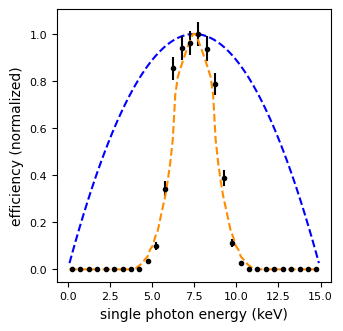

In [25]:
fname = 'fig6_'+plot_folder

E1 = np.linspace(0.1,14.9,100)
x_cen = 258+2
y_cen = 257+2
cce, d1 = ts.conversion_efficiency(E1)
da = ts.detector_acceptance(d1, scan_info['x_cen'], scan_info['y_cen'])
tot = ts.tot_acceptance(E1)
ta = ts.total_acceptance(cce, da, tot)
datas = df_dt_Etot['E_1'].values
step = .5

counts0, edges0 = ts.histogram1d_fast(df_dp_Etot2_dt['E_1'], bins = np.arange(0, 15 + step, step), range=[0, 15])

bin_centers0 = (edges0[1:] + edges0[:-1]) / 2
counts1, edges1 = ts.histogram1d_fast(df_dp_Etot2_dt['E_2'], bins = np.arange(0, 15 + step, step), range=[0,15])
print(edges1)
counts_total = counts0 + counts1
bin_centers1 = (edges1[1:] + edges1[:-1]) /2 

errors0 = np.sqrt(counts0)
errors1 = np.sqrt(counts1)

plt.figure(figsize=figsize_sing)

plt.plot(E1, cce, '--', color='blue', label='Theory')
plt.errorbar(x=bin_centers0, y=counts_total / np.max(counts_total), yerr=np.sqrt(counts_total) / np.max(counts_total),
                ecolor='black', color='black', fmt='.', label='Exp. Data')
plt.plot(E1, ta[1], '--', color='darkorange',
            label='Model')
#plt.legend(fontsize=legendsize, loc='upper right')

plt.tick_params(axis='both', which='major', labelsize=ticksize)

plt.xlabel('single photon energy (keV)', fontsize=labelsize)
plt.ylabel('efficiency (normalized)', fontsize=labelsize)

if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

## ToT vs energy from radius

[ 7.   7.5  8.   8.5  9.  10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5 16. ]


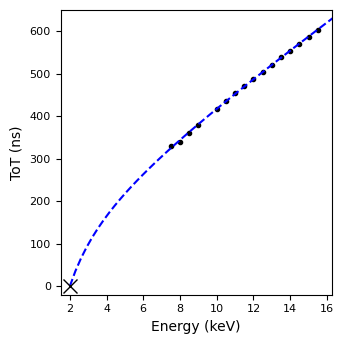

In [26]:
fname = 'efig3a_'+plot_folder

data =np.load('/nsls2/data/chx/legacy/analysis/2023_2/qmicroscope/jhanrahan/chip_tot_info.npz')
modes1 = data['modes1']; modes2 = data['modes2']; modes3 = data['modes3']; modes4 = data['modes4']
means1 = data['means1']; means2 = data['means2']; means3 = data['means3']; means4 = data['means4']
energies = data['energy']

print(energies)

energies_f0 = energies[1:-1]
means4_f0 = means4[1:-1]

energies_f = np.concatenate(([2], energies[1:-1]))
means1_f = np.concatenate(([0], means1[1:-1]))
means2_f = np.concatenate(([0], means2[1:-1]))
means3_f = np.concatenate(([0], means3[1:-1]))
means4_f = np.concatenate(([0], means4[1:-1]))

# should move some of this to tpxspdc
def ftot(x, a, b, c, t):
    return a*x + b - c/(x-t)

def ftot_inv(y, a, b, c, t):
    numerator = a*t - b + y + np.sqrt(a**2 * t**2 + 2*a*b*t + 4*a*c - 2*a*t*y + b**2 - 2*b*y + y**2)
    return numerator / (2 * a)

p1opt, p1cov = curve_fit(ftot, energies_f, means1_f, p0 = [1/0.035, 100, 500, -1.5], maxfev = 1000000)
p2opt, p2cov = curve_fit(ftot, energies_f, means2_f, p0 = [1/0.035, 100, 500, -1.5], maxfev = 1000000)
p3opt, p3cov = curve_fit(ftot, energies_f, means3_f, p0 = [1/0.035, 100, 500, -1.5], maxfev = 1000000)
p4opt, p4cov = curve_fit(ftot, energies_f, means4_f, p0 = [1/0.035, 100, 500, -1.5], maxfev = 1000000)

e_dom = np.linspace(2, 17, 50)

plt.figure(figsize=figsize_sing)
plt.plot(energies_f[1:], means4_f[1:], '.', markersize=6, label='calibration', color='black')
plt.plot(e_dom, ftot(e_dom, *p4opt), '--', color='blue', label='a={:.2f}, b={:.1f}, c={:.1f}, t={:.2f}'.format(p4opt[0], p4opt[1], p4opt[2], p4opt[3]))
plt.plot([2], [0], marker='x', markersize='10', color='black')
plt.xlabel('Energy (keV)', fontsize=labelsize)
plt.ylabel('ToT (ns)', fontsize=labelsize)
plt.ylim([-20, 650])
plt.xlim([1.5,16.25])
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

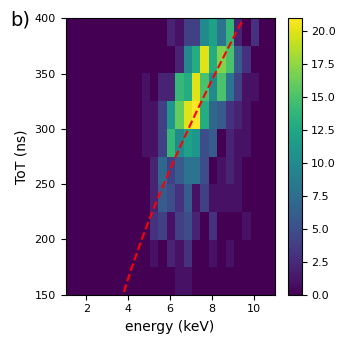

In [27]:
fname = 'efig3b_'+plot_folder

ch_no = 4

ch_1 = df_dp_Etot2_dt.loc[df_dp_Etot2_dt['chan_1'] == ch_no, ['ToT_sum_1', 'E_1']].values
ch_2 = df_dp_Etot2_dt.loc[df_dp_Etot2_dt['chan_2'] == ch_no, ['ToT_sum_2', 'E_2']].values
ch = np.concatenate((ch_1, ch_2))

plt.figure(figsize=figsize_sing)
# data = plt.hist2d(ch[:, 1], ch[:, 0], bins = [25,10], range=[[1,11],[150,400]])
data, xedge, yedge = ts.histogram2d_fast(ch[:, 1], ch[:, 0], bins = [25,10], range=[[1,11],[150,400]])
plt.imshow(data, origin='lower', extent=[xedge[0], xedge[-1], yedge[0], yedge[-1]],aspect='auto')
plt.plot(e_dom, ftot(e_dom, *p4opt), '--', color='red')
plt.xlim(1, 11)
plt.ylim(150, 400)
plt.xlabel('energy (keV)', fontsize=labelsize)
plt.ylabel('ToT (ns)', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.annotate('b)', xy=(0, 1), xycoords='axes fraction', xytext=(-40, 6), 
            textcoords='offset points', ha='left', va='top', fontsize=labelsize+4)
cbar = plt.colorbar(shrink=1)
cbar.ax.tick_params(labelsize=ticksize)
plt.tight_layout()
if save_plots: plt.savefig(plot_folder+'/'+fname+'.png', dpi=dpi)
plt.show()
plt.close()

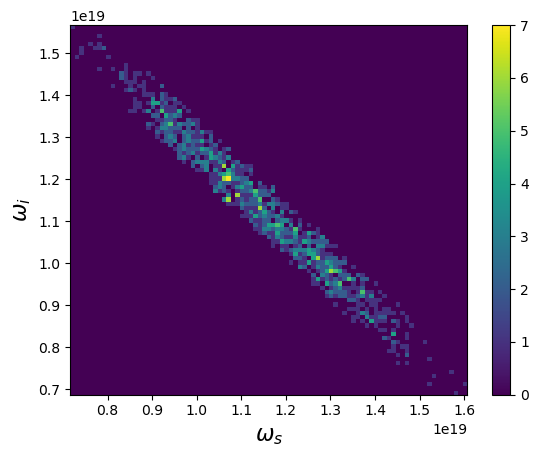

ρ_w = -0.97964 +/- 0.00026
Δ(ω_s + ω_i)Δ(t_s - t_i) = 0.101 


0.1014123437003043

In [28]:
ts.entanglement_test(df_dp_Etot2_dt)

In [29]:
ts.entanglement_test(df_dp_Etot2_dt, prints = False, plot = False)

0.1014123437003043

In [30]:
print("Best coordinate is most likely at {} with dp = {} pix and metric = {:.1f}".format(best_coord, best_dp, best_metric))
#print("Set coordinate was [{}, {}]".format(scan_info['x_cen'], scan_info['y_cen']))
print("Optimal detuning angle found: {:.5f}".format(optimal_del_theta))
print(f"Total number of pairs: {len(df_dp_Etot2_dt)}")

Best coordinate is most likely at [254, 257] with dp = 3.75 pix and metric = 355.6
Optimal detuning angle found: 0.03996
Total number of pairs: 1155


In [31]:
tend = time.time()

print(tend-tstart)

1015.2378108501434


In [ ]:
import os
os._exit(0)